# Participez à la conception d'une voiture autonome - Data_Generator 

**Future vision transport** est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Je suis l’un des ingénieurs IA au sein de l’équipe R&D de cette entreprise, membre de l equipe **Segmentation des images**:

    - acquisition des images en temps réel
    - traitement des images
    - segmentation des images (c’est vous !)
    - système de décision


Le but de ce projet est de concevoir un premier modèle de segmentation d’images qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

Mon rôle ici est de fournir à l équipe en charge du système de décision (4), une API simple à utiliser qui prend en entrée une image et renvoie la segmentation de l’image de l’algo.

Pour ça, on utilisera le jeu de données CityScapes.

## Conception du Data generator

Dans ce notebook, l'objectif est de **concevoir notre Data_Generator**, servant à faciliter la manipulation du jeu de données lors des phases d'entrainement et de tests.

2 Chapitres distincts:
1. Analyse des données
2. Création du Data Generator (sous forme de classe python, entièrement automatisé)

Une fois finalisé, nous sauvegarderons notre data_generator dans notre fichier recensant les fonctions "Functions_custo_by_Nico.py", pour une réutilisation ultérieure lors de l'entrainement du modèle UNET.


In [247]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 
#import seaborn
#from matplotlib.image import imread

#Import functions created
from labels import *
from labels import labels, name2label, id2label, trainId2label

import cv2
import albumentations as A
# calling functions
Test_Imported_Functions()


Functions have been properly imported !


## 1. Analyse des données

Le jeu de donnée est disponible en télechargement [ici](https://www.cityscapes-dataset.com/dataset-overview/).

Dans le chapitre suivant, nous executerons les 3 travaux :

  - 1.a. Lecture des données
  - 1.b. Analyse des données
  - 1.c. Nettoyage des données

Le Jeu de donnée est cronstruit de la façon suivante :
- `gtFine/` : Dossier contenant les images transformées
  - `test/`, `train/` and `val/` : 3 Dossiers pour différencier les jeux de données
    - `berlin/`, `frankfurt/`, `munich/`, ... : Dossiers par villes, contenant les images
      - `*_gtFine_color.png` : Images colorées
      - `*_gtFine_instanceIds.png` : Images avec faible variations de gris, suivant les InstanceIds
      - `*_gtFine_labelIds.png` : Images avec faible variations de gris, suivant les labelIds
      - `*_gtFine_polygons.json` : JSON contenant les formes ploygones associés aux images
- `leftImg8bit` : Dossier contenant les images natives
  - `test/`, `train/` and `val/` : 3 Dossiers pour différencier les jeux de données
    - `berlin/`, `frankfurt/`, `munich/`, ... : Dossiers par villes, contenant les images
      - `*_leftImg8bit.png` : Images natives variations de gris

### 1.a. Lecture des données

Nous préparons ici les chemins d'accès aux données

In [248]:
src_path = os.path.abspath(os.path.join("../IA_Project8_Openclassrooms_VoitureAutonome"))
if src_path not in sys.path:
    sys.path.append(src_path)

#Build Data path
data_url_gtfine = os.path.join(src_path, "Dataset", "P8_Cityscapes_gtFine_trainvaltest", "gtFine")
data_url_leftlmg = os.path.join(src_path, "Dataset", "P8_Cityscapes_leftImg8bit_trainvaltest", "leftImg8bit")

### 1.b. Analyse des données

Nous listons ici tous les fichiers, et stockons les informations dans un dataframe, pour une future utilisation

In [249]:
df_gtfine = list_files(data_url_gtfine)
df_leftlmg = list_files(data_url_leftlmg)
df = pd.concat([df_gtfine, df_leftlmg], ignore_index = None, axis = 0)
df = get_info_from_filename(df)
df.head(2)

Phase    City                                         File  \
0  test  berlin        berlin_000000_000019_gtFine_color.png   
1  test  berlin  berlin_000000_000019_gtFine_instanceIds.png   

                                                Path File_id1 File_id2  \
0  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...   000000   000019   
1  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...   000000   000019   

  File_type     File_unique_index  
0    gtFine  berlin_000000_000019  
1    gtFine  berlin_000000_000019

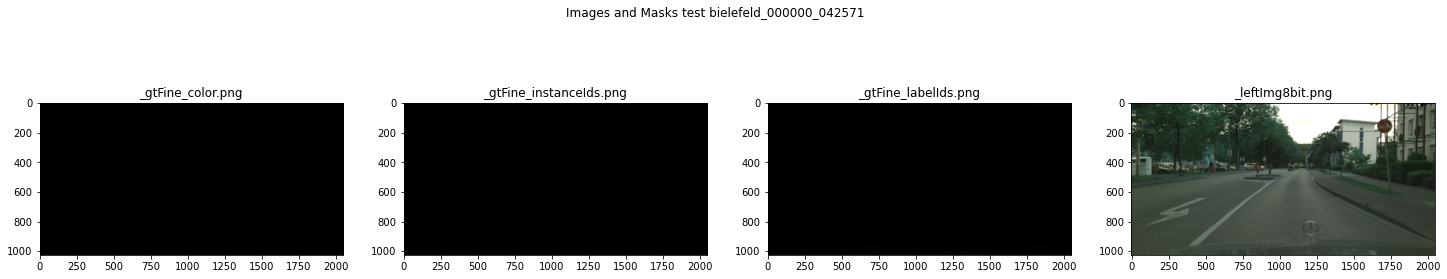

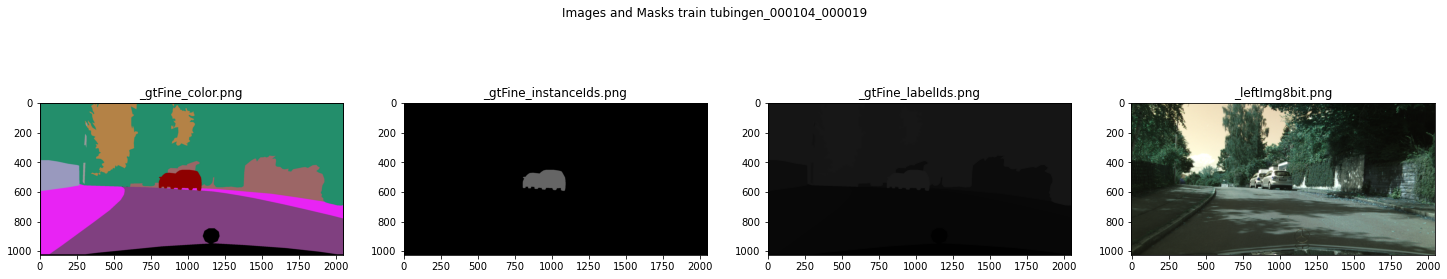

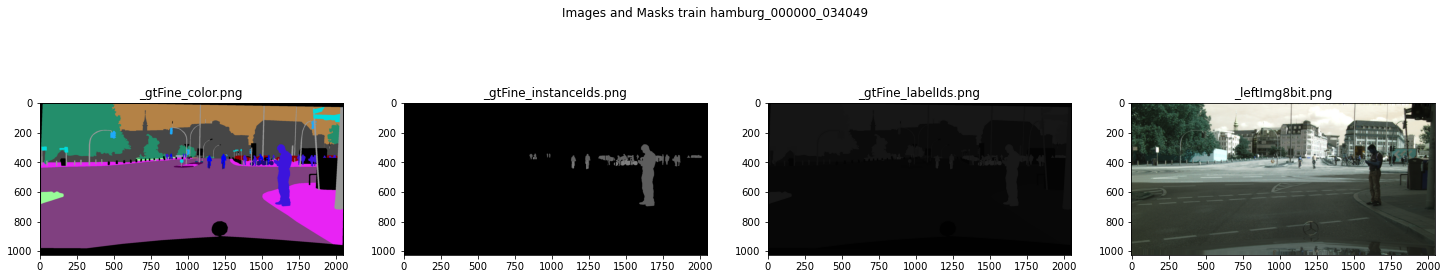

In [250]:
#Prendre un echantillon aléatoire, et afficher les photos appartenant à la même prise de vue, mais ayant subit différentes transformations
n_sample = 3
files_ids_random = df.loc[df['File_type'] == 'gtFine',:].sample(n_sample)
files_ids_random.drop_duplicates(keep='first', inplace=True)
title=['_gtFine_color.png', '_gtFine_instanceIds.png', '_gtFine_labelIds.png', '_leftImg8bit.png']
for i in files_ids_random.values:
    sources_images = df.loc[((df['Phase'] == i[0]) & (df['City'] == i[1]) & (df['File_id1'] == i[4]) & (df['File_id2'] == i[5])),:].sort_values(by=['File_type'])
    path_gtfine_color = os.path.join(data_url_gtfine, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_gtFine_color.png')
    path_gtfine_instanceIds = os.path.join(data_url_gtfine, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_gtFine_instanceIds.png')
    path_gtfine_labelIds = os.path.join(data_url_gtfine, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_gtFine_labelIds.png')
    path_leftlmg = os.path.join(data_url_leftlmg, i[0], i[1], i[1] + '_' + i[4] + '_' + i[5] + '_leftImg8bit.png')
    filepaths = [path_gtfine_color, path_gtfine_instanceIds, path_gtfine_labelIds, path_leftlmg]
    plt.figure(figsize=(25, 5))
    plt.subplots_adjust(hspace=0.5)
    for j in range(4):
        #print(filepaths[j])
        plt.subplot(140 + 1 + j)
        plt.title(title[j])
        image = cv2.imread(filepaths[j])
        plt.imshow(image)
        plt.grid(False)
    plt.suptitle(f'Images and Masks {(i[0])} {(i[1])}_{(i[4])}_{(i[5])}')
    plt.show()

### 1.c. Nettoyage des données

Dans le sous-cahpitre suivant, nous allons conserver et associer les Images avec les Masques LabelIds.

In [251]:
clean_df = link_images_masks(df_gtfine, df_leftlmg)
clean_df.head(2)

Phase    City                                File_x  \
0  test  berlin  berlin_000000_000019_leftImg8bit.png   
1  test  berlin  berlin_000001_000019_leftImg8bit.png   

                                              Path_x File_id1 File_id2  \
0  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...   000000   000019   
1  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...   000001   000019   

       File_type_x     File_unique_index  \
0  leftImg8bit.png  berlin_000000_000019   
1  leftImg8bit.png  berlin_000001_000019   

                                     File_y  \
0  berlin_000000_000019_gtFine_labelIds.png   
1  berlin_000001_000019_gtFine_labelIds.png   

                                              Path_y File_type_y  
0  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...      gtFine  
1  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...      gtFine

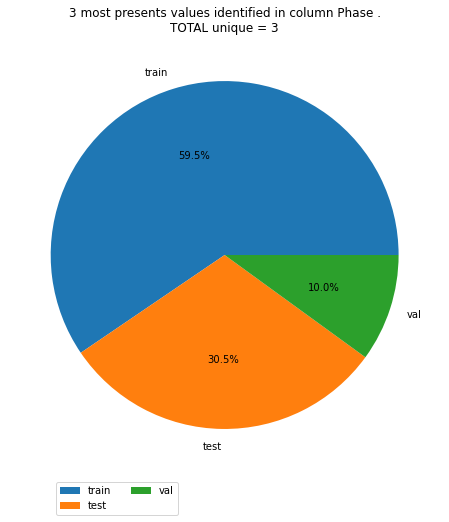

Phase
train   2975
test    1525
val      500

In [252]:
#Représenter le % des données, par train, val et test
plot_ntops_pie(clean_df, 'Phase', 3, False, False)

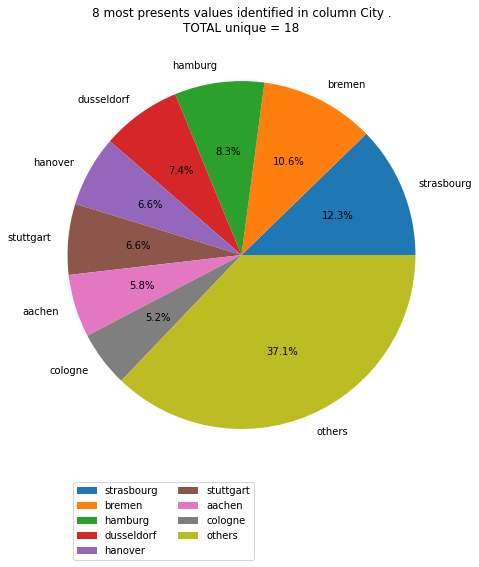

City
strasbourg   365
bremen       316
hamburg      248
dusseldorf   221
hanover      196
stuttgart    196
aachen       174
cologne      154
others      1105

In [253]:
#Représenter le % des données d'entrainement, pour les 8 villes les plus représentés
plot_ntops_pie(clean_df.loc[clean_df['Phase'] == 'train', :], 'City', 8, True, False)

In [254]:
#Représenter la proportion des données par ville
#plot_occurence_line(clean_df, 'City')

In [255]:
clean_df.head(2)

Phase    City                                File_x  \
0  test  berlin  berlin_000000_000019_leftImg8bit.png   
1  test  berlin  berlin_000001_000019_leftImg8bit.png   

                                              Path_x File_id1 File_id2  \
0  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...   000000   000019   
1  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...   000001   000019   

       File_type_x     File_unique_index  \
0  leftImg8bit.png  berlin_000000_000019   
1  leftImg8bit.png  berlin_000001_000019   

                                     File_y  \
0  berlin_000000_000019_gtFine_labelIds.png   
1  berlin_000001_000019_gtFine_labelIds.png   

                                              Path_y File_type_y  
0  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...      gtFine  
1  c:\Users\blanc\OpenClassrooms\IA_Project8_Open...      gtFine

## 2. Construction du Data_Generator

Afin d'entrainer notre futur réseau de neurones, il est essentiel de considérer le volume du jeu de données et les limitations mémoires.

Ainsi, nous devons utiliser un data_generator qui créé des donnée en batches et qui alimentera notre réseau lors de la phase d'entrainement.

Dans le chapitre ci-dessous, nous allons **concevoir une data_generator** capable d'alimenter nos modèles de segmentation, **à partir du dataframe créé ci-dessus (clean_df)**

Diffférentes documentation disponible:

- [Step by Step Data Generator - Skeleton](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)
- [Custom Data Generator - En Français](https://deeplylearning.fr/cours-pratiques-deep-learning/realiser-son-propre-generateur-de-donnees/)

Nous allons découper ce chapitre du  notebook en 3 parties distinctes:
- 2.a. Data Generator 1ere version (Création de la Class - Affichages des Images et Masques, avec Augmentations et Normalisation)
- 2.b. Conversion des Masques
- 2.c. Data Generator 2nde version (Insertion de la conversion des Masques)

### 2.a. Data Generator 1ere version (Création de la Class - Affichages des Images et Masques, avec Augmentations et Normalisation)

In [256]:
# # DATALOADER - Notre classe hérite de la classe Keras.utils.Sequence
# # Elle permet de créer un générateur de données
# # Cette classe parente vous assure dans le cas ou vous souhaitez utiliser du calcul parallèle avec vos threads, de garantir de parcourir une seule et unique fois vos données au cours d’une époch
# class Dataloader_simple(keras.utils.Sequence):
#     """Load data from dataset to build bacthes
#     Args:
#         dataset : dataframe listing data and paths
#         n_sample : to work with a reduced dataset
#         batch_size: Integet number of images in batch.
#         shuffle: Boolean, if `True` shuffle dataset each epoch.
#         resize: Boolean,  if `True` resize images and mask to same dimensions
#         resize_width & resize_height: New dimensions after resizing
#         display: display images when calling dataloader
#         phase: allow to set if dataloader shall filter on train, val or test images/masks
#         augmentation: Variable defining augmentation of image and mask
#         normalization: Boolean,  if `True` normalizes images and masks RGB values ; The range for each individual colour is 0-255
#     """
#     # We provide one dataset, containing labelIds and 
#     def __init__(self, dataset, n_sample, batch_size=1, shuffle=False, resize=None, resize_width=256, resize_height=128, display=None, phase='train', augmentation=None, normalization=None):
#         self.n_sample = n_sample
#         self.phase = phase
#         self.dataset = dataset.loc[dataset['Phase'] == self.phase, :].sample(self.n_sample) #ou dataset si on veut prendre tour le jeu de donnée
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.resize = resize
#         self.resize_width = resize_width
#         self.resize_height = resize_height
#         self.augmentation = augmentation
#         self.normalization = normalization
#         self.display = display
#         self.on_epoch_end()

#     def __getitem__(self, i):
#         # collect batch images and masks
#         start = i * self.batch_size
#         stop = (i + 1) * self.batch_size
#         #print('start barch is ', start)
#         #print('stop barch is ', stop)
#         images = []
#         masks = []
#         for j in range(start, stop):
#             # Store entire paths to image_file and mask_file variable
#             image_file = list(self.dataset['Path_x'])[j]
#             mask_file = list(self.dataset['Path_y'])[j]
#             unique_index_file = list(self.dataset['File_unique_index'])[j]

#             # OpenImages and masks using OpenCV ibrary, and convert in np array
#             image = cv2.imread(image_file)
#             #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#             mask = cv2.imread(mask_file)
#             #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            
#             # apply resize
#             if self.resize:
#                 dim = (self.resize_width, self.resize_height)
#                 original_height = image.shape[0]
#                 original_width = image.shape[1]
#                 original_channels = image.shape[2]
#                 image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) # resize image
#                 mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
#                 new_height = image.shape[0]
#                 new_width = image.shape[1]
#                 new_channels = image.shape[2]
                

#             # apply display
#             if self.display:
#                 #Display Image and Mask
#                 plt.figure(figsize=(25, 5))
#                 plt.subplots_adjust(hspace=0.5)
#                 plt.subplot(120 + 1 + 0)
#                 plt.imshow(image)
#                 plt.subplot(120 + 1 + 1)
#                 plt.imshow(mask)
#                 plt.grid(False)
#                 plt.suptitle(f'Images and Masks {unique_index_file}')
#                 plt.show()
#                 if self.resize:
#                     print('original height was ', original_height, ' and new height is ', new_height)
#                     print('original width was ', original_width, ' and new width is ', new_width)
#                     print('original channels was ', original_channels, ' and new channels is ', new_channels)
                    

#             # apply normalization : Normalizing RGB values ; The range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
#             if self.normalization:
#                 normalizedImg = np.zeros((800, 800))
#                 image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX) #image/255 ou normalizedImg
#                 mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX) #mask/255
#                 # apply display
#                 if self.display:
#                     print(f'----------------Normalized Image and Mask {j} from batch collected-----------------')
#                     #Display Image and Mask
#                     plt.figure(figsize=(25, 5))
#                     plt.subplots_adjust(hspace=0.5)
#                     plt.subplot(120 + 1 + 0)
#                     plt.imshow(image)
#                     plt.subplot(120 + 1 + 1)
#                     plt.imshow(mask)
#                     plt.grid(False)
#                     plt.suptitle(f'Normalized Images and Masks {unique_index_file}')
#                     plt.show()
            
#             # apply augmentations
#             if ((self.augmentation is not None) & (self.phase == 'train')):
#                 # Augment an image
#                 sample = self.augmentation(image=image, mask=mask)
#                 augmented_image, augmented_mask = sample['image'], sample['mask']
#                 # apply display
#                 if self.display:
#                     print(f'----------------Augmented Image and Mask {j} from batch collected-----------------')
#                     #Display Image and Mask
#                     plt.figure(figsize=(25, 5))
#                     plt.subplots_adjust(hspace=0.5)
#                     plt.subplot(120 + 1 + 0)
#                     plt.imshow(augmented_image)
#                     plt.subplot(120 + 1 + 1)
#                     plt.imshow(augmented_mask)
#                     plt.grid(False)
#                     plt.suptitle(f'Augmented Images and Masks {unique_index_file}')
#                     plt.show()
#                     images.append(augmented_image)
#                     masks.append(augmented_mask)
                    
#             # append image and mask to batch
#             images.append(image)
#             masks.append(mask)   
#             print(f'---------------- Image and Mask {j} from batch collected in Data Generator-----------------')

#         # transpose list of lists
#         image_batch = np.stack(images, axis=0) #A confirmer si images ou image
#         mask_batch = np.stack(masks, axis=0) #A confirmer si masks ou mask

#         #Add 1 dimension to return image_batch and mask_batch in 4 dimensions (batch number, height, width, channels), avec channel = 1 pour les masques et =3 pour les images
#         if len(mask_batch.shape) == 3:
#             mask_batch = np.expand_dims(mask_batch, axis = 3)

#         #print('mask_batch shape is ', mask_batch.shape)
#         return image_batch, mask_batch
    
#     def __len__(self):
#         """Denotes the number of batches per epoch"""
#         return len(self.dataset) // self.batch_size
    
#     def on_epoch_end(self):
#         """Callback function to shuffle dataset each epoch"""
#         if self.shuffle:
#             np.random.shuffle(self.dataset.values)

In [257]:
# Divide the number of images in directory by batch_size 
n_sample = 20 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 2 #Pour les tests, nous limitons le batch_size à 2 images
shuffle = True #La fonction shuffle permet de mélanger les images de manière aléatoire, à chaque lancement du data_generator  
resize = True #La fonction resize permet de redimensionner les images et les masques à la taille souhaitée (voir ci-dessous)
resize_width = 512
resize_height = 256
display_image_mask = True
phase = 'train'

# Declare an augmentation pipeline
# augmentation = None 
augmentation = A.Compose(
                    [#A.RandomCrop(width=512, height=256), 
                    A.Rotate(25),
                    A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
                    #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
                    #A.IAAPerspective(p=0.5), 
                    #A.HorizontalFlip(p=0.5),
                    A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
                    ])

normalization = True
dataloader = Dataloader_simple(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, display_image_mask, phase, augmentation, normalization)


In [258]:
# Denotes the number of batches per epoch = Number of picture / batch_size
len(dataloader)


10

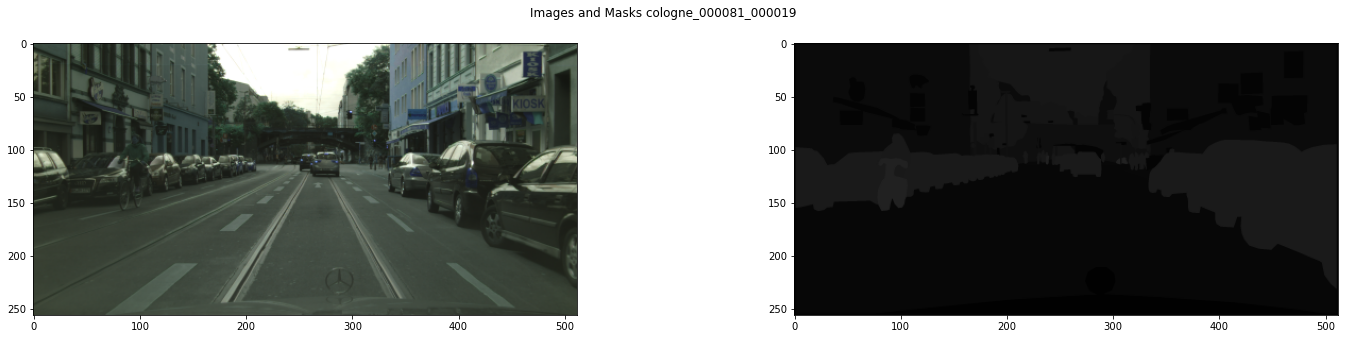

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 0 from batch collected-----------------


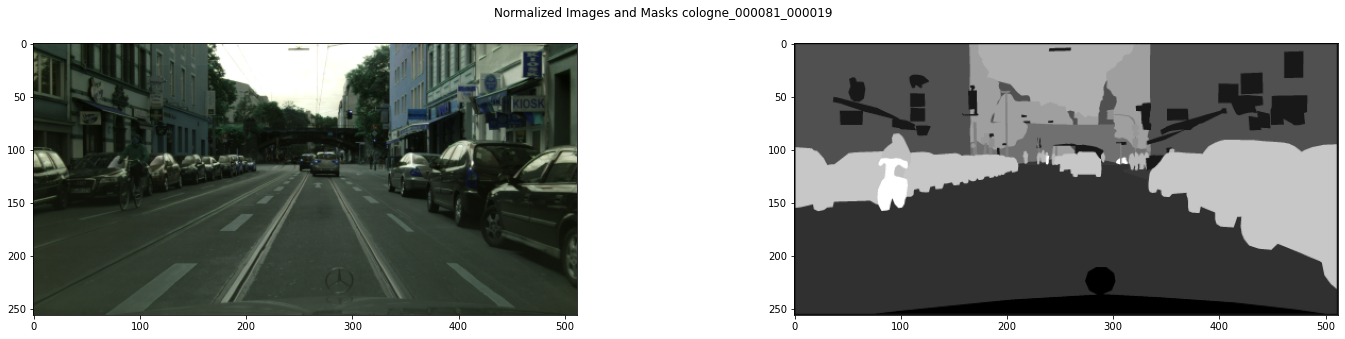

----------------Augmented Image and Mask 0 from batch collected-----------------


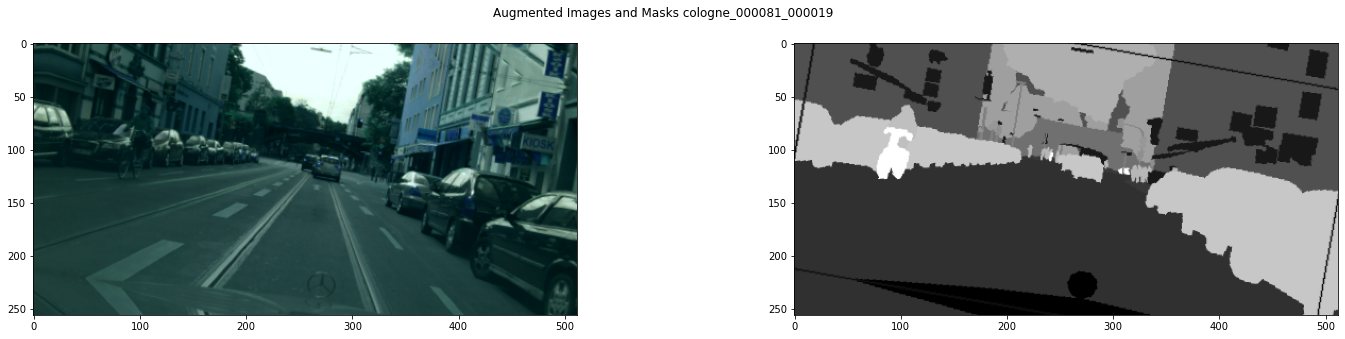

---------------- Image and Mask 0 from batch collected in Data Generator-----------------


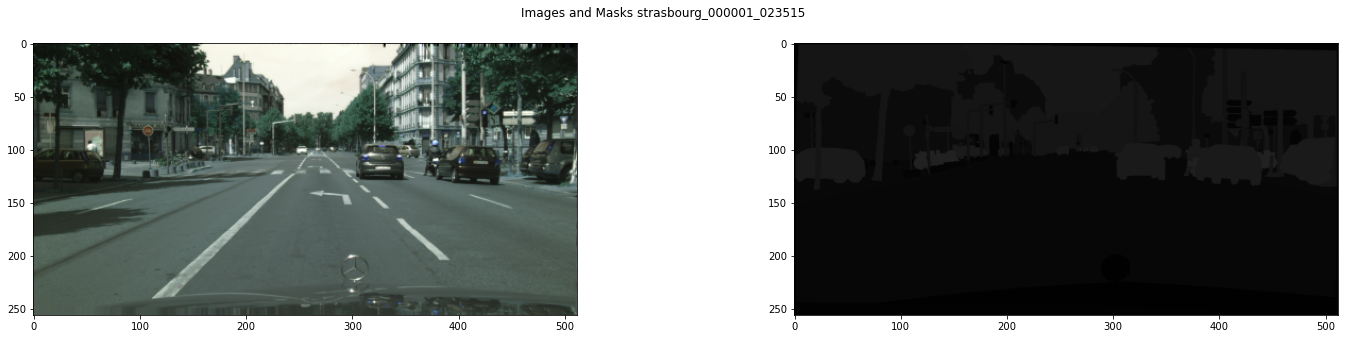

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 1 from batch collected-----------------


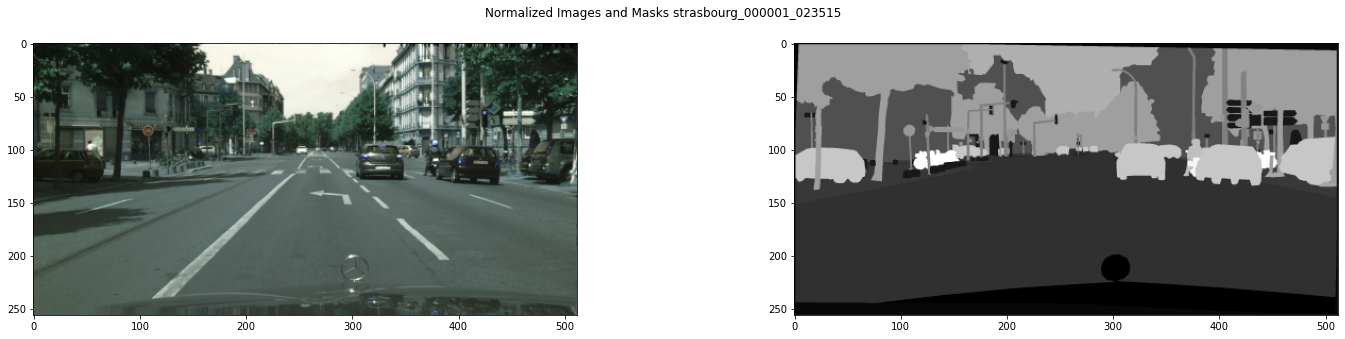

----------------Augmented Image and Mask 1 from batch collected-----------------


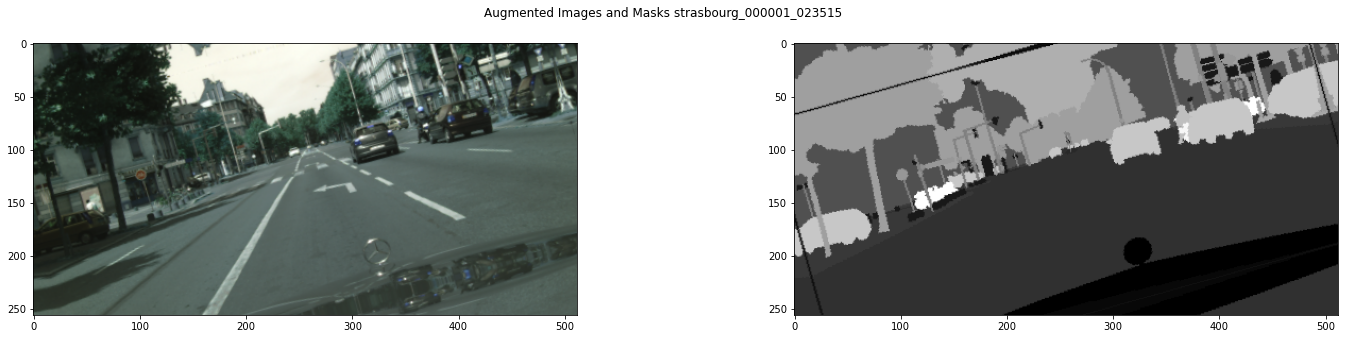

---------------- Image and Mask 1 from batch collected in Data Generator-----------------


(4, 256, 512, 3)

In [259]:
# Each dataloade call requests a batch index between 0 and the total number of batches, as specified in len(dataloader)

# This returns the images and mask for batch 0 numpy array
#image_batch, mask_batch = dataloader[0]

#This returns image_batch and mask_batch shapes
dataloader[0][0].shape

Au travers du test ci-dessus, nous notons que :
 - Le format du Data Loader retourne bien les images et les masques associés, pour chaque batch
 - Les Images et masques sont correctement redimensionnés (height, Width, Channel)
 - Les Images et Masques sont augmentés (pour les données d'entrainement)


### 2.b. Conversion des categories / classes

Tout d'abord, nous cherchons à comprendre la structure des couleurs des fichiers labelIds, [Voir Source GitHub](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)

Nous notons par cet exercice, que **34 classes distinctes sont représentées**.
Notre objectifs est de **travailler un segmentation à 8** , nous devons donc renommer/convertirs des 34classes en 8classes.

Voici les 8 classes attendues: 
 - "void"
 - "flat"
 - "construction"
 - "object"
 - "nature"
 - "sky"
 - "human"
 - "vehicle"


 Nous allons ci-dessous chercher à convertir nos masques, en utilisant le dictionnaire de Conversion (ID to CatID) disponible

In [260]:
    from labels import labels, name2label, id2label, trainId2label
    # # Example usages:
    # # Map from name to label
    # name = 'ego vehicle'
    # print(labels[id])
    # id   = name2label[name].id
    # print("ID of label '{name}': {id}".format( name=name, id=id ))

    # # Map from trainID to label
    # trainId = 0
    # name = trainId2label[trainId].name
    # print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))

    id = 4
    # Map from id to catId
    catId = id2label[id].categoryId
    print("CategoryID of id '{id}': {catId}".format( id=id, catId=catId ))

    # Map from ID to label
    category = id2label[id].category
    print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

CategoryID of id '4': 0
Category of label with ID '4': void


In [261]:
def convert(list):
    return tuple(list)
def count_color_rgb(image):
    all_color = {}
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            color =  convert(image[x,y].tolist())
            if not color in all_color.keys():
                all_color[color] = 1
            else:
                all_color[color] += 1
    return sorted(all_color.items())


In [262]:
# Nous vérifions sur un exemple la structure du fichier, en comptabilisant les pixels par IDs
i = 2500
print(list(clean_df['Path_y'])[i])

# Open mask image
mask_test = cv2.imread(list(clean_df['Path_y'])[i])
# Count the number of unique Categories in the mask -=(34 in total)
count_color_rgb(mask_test)

c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_gtFine_trainvaltest\gtFine\train\dusseldorf\dusseldorf_000150_000019_gtFine_labelIds.png


[((1, 1, 1), 81534),
 ((3, 3, 3), 31634),
 ((4, 4, 4), 64965),
 ((5, 5, 5), 5697),
 ((7, 7, 7), 849983),
 ((8, 8, 8), 19154),
 ((9, 9, 9), 54851),
 ((11, 11, 11), 700926),
 ((17, 17, 17), 6936),
 ((19, 19, 19), 3228),
 ((20, 20, 20), 11847),
 ((21, 21, 21), 47136),
 ((23, 23, 23), 89686),
 ((24, 24, 24), 1997),
 ((26, 26, 26), 122288),
 ((33, 33, 33), 5290)]

In [263]:
# Après réduction de dimensions, nous regardons le format de l'image en numpy array
mask_test_resized = cv2.resize(mask_test, (10, 10), interpolation = cv2.INTER_AREA)
mask_test_resized

array([[[10, 10, 10],
        [11, 11, 11],
        [11, 11, 11],
        [15, 15, 15],
        [22, 22, 22],
        [22, 22, 22],
        [12, 12, 12],
        [11, 11, 11],
        [10, 10, 10],
        [ 8,  8,  8]],

       [[11, 11, 11],
        [11, 11, 11],
        [10, 10, 10],
        [12, 12, 12],
        [20, 20, 20],
        [20, 20, 20],
        [11, 11, 11],
        [11, 11, 11],
        [ 9,  9,  9],
        [ 9,  9,  9]],

       [[11, 11, 11],
        [11, 11, 11],
        [ 9,  9,  9],
        [11, 11, 11],
        [21, 21, 21],
        [15, 15, 15],
        [11, 11, 11],
        [13, 13, 13],
        [10, 10, 10],
        [10, 10, 10]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        [ 9,  9,  9],
        [18, 18, 18],
        [13, 13, 13],
        [12, 12, 12],
        [13, 13, 13],
        [11, 11, 11],
        [11, 11, 11]],

       [[20, 20, 20],
        [20, 20, 20],
        [22, 22, 22],
        [15, 15, 15],
        [19, 19, 19],
  

In [264]:
# cats = {
# 	'construction': [11, 12, 13, 14, 15, 16],
# 	'flat': [7, 8, 9, 10],
# 	'human': [24, 25],
# 	'nature': [21, 22],
# 	'object': [17, 18, 19, 20],
# 	'sky': [23],
# 	'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1],
# 	'void': [0, 1, 2, 3, 4, 5, 6],
# }

# def convert_mask(img):
#     """Cette méthode permet de convertir l'image '_labelids.png' du jeu de données de CityScapes.
#     La méthode permet de récupérer l'image au format one_hot_encoder ou au format label_encoder.
#     arguments:
#     - img (type numpy.array): image du jeu de données CityScapes '...labelids.png' au format numpy  
#     return:
#     mask (type numpy.array) : mask pour la segmentation sémantique au format label encoder avec les 8 catégories principal (void, flat, construction, object, nature, sky, human, vehicle)
#     """
#     #print(len(img.shape))
#     if len(img.shape) == 3:
#         img = np.squeeze(img[:, :, 0])
#     else:
#         img = np.squeeze(img)
#         #print(img.shape)
#     mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint16)
#     print(mask.shape)
#     for i in range(-1, 34):
#         if i in cats['void']: 
#             #Logical OR is applied to the elements of mask and labelIds_img. If mask.shape != labelIds_img.shape,.
#             mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
#         elif i in cats['flat']:
#             mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
#         elif i in cats['construction']:
#             mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
#         elif i in cats['object']:
#             mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
#         elif i in cats['nature']:
#             mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
#         elif i in cats['sky']:
#             mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
#         elif i in cats['human']:
#             mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
#         elif i in cats['vehicle']:
#             mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
#     return np.array(np.argmax(mask, axis=2), dtype='uint8')

In [265]:
# Après réduction de dimension, nous convertissons chaque pixel en utilisant le dictionnaire de compatibilité
#onehotencoder = False
mask_test_resized_converted = convert_mask(mask_test_resized)
mask_test_resized_converted

1. img.shape : (10, 10, 3)
2. img.shape : (10, 10)
3. mask.shape : (10, 10, 8)
4. mask.shape : (10, 10, 8)


array([[1, 2, 2, 2, 4, 4, 2, 2, 1, 1],
       [2, 2, 1, 2, 3, 3, 2, 2, 1, 1],
       [2, 2, 1, 2, 4, 2, 2, 2, 1, 1],
       [2, 2, 2, 1, 3, 2, 2, 2, 2, 2],
       [3, 3, 4, 2, 3, 2, 4, 5, 1, 1],
       [4, 2, 1, 1, 1, 1, 1, 2, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

1. img.shape : (1024, 2048, 3)
2. img.shape : (1024, 2048)
3. mask.shape : (1024, 2048, 8)
4. mask.shape : (1024, 2048, 8)


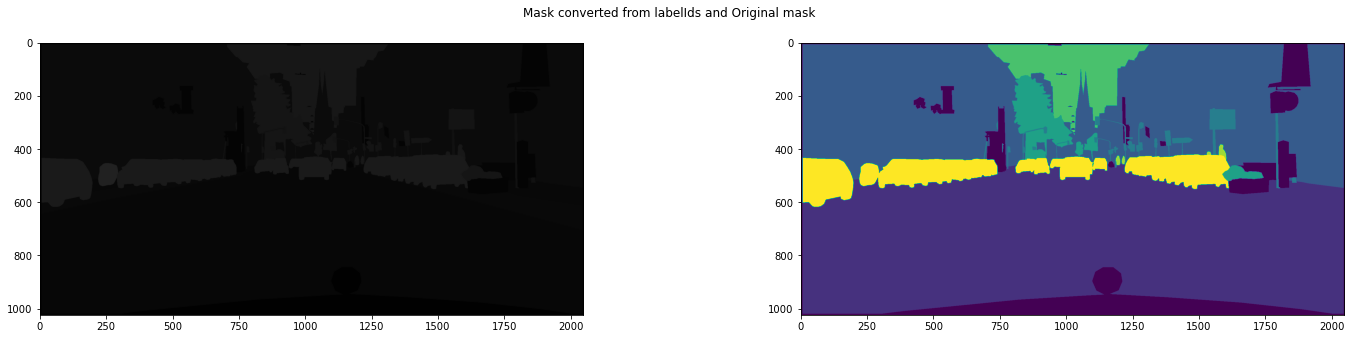

In [266]:
#
mask_test = cv2.imread(list(clean_df['Path_y'])[i])
mask_converted = convert_mask(mask_test)
#image_test = cv2.imread("c:/Users/blanc/OpenClassrooms/IA_Project8_Openclassrooms_VoitureAutonome/Dataset/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/" + "strasbourg/" + "strasbourg_000000_029051_gtFine_labelIds.png")

#Conversion = Ici label_Encoder
#mask_converted = convert_mask(cv2.imread("c:/Users/blanc/OpenClassrooms/IA_Project8_Openclassrooms_VoitureAutonome/Dataset/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/" + "strasbourg/" + "strasbourg_000000_029051_gtFine_labelIds.png",0))
#mask_origin = cv2.imread("c:/Users/blanc/OpenClassrooms/IA_Project8_Openclassrooms_VoitureAutonome/Dataset/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/" + "strasbourg/" + "strasbourg_000000_029051_gtFine_color.png",0)

plt.figure(figsize=(25, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(120 + 1 + 0)
plt.imshow(mask_test)
plt.subplot(120 + 1 + 1)
plt.imshow(mask_converted)
plt.grid(False)
plt.suptitle(f'Mask converted from labelIds and Original mask')
plt.show()

Comme il est précisé dans l'énnoncé du projet, il est essentiel de travailler autour des 8 catégories principales.

Ainsi, nous allons reprendre notre Data Generator 1ere version, afin qu'il prenne en charge la Conversion des masques LabelIds.png dans les 8 catégories.

### 2.c. Data Generator 2nde version (Inclure la conversion des Masques en 8 categories)



In [267]:
# # DATALOADER - Notre classe hérite de la classe Keras.utils.Sequence
# # Elle permet de créer un générateur de données
# # Cette classe parente vous assure dans le cas ou vous souhaitez utiliser du calcul parallèle avec vos threads, de garantir de parcourir une seule et unique fois vos données au cours d’une époch
# class Dataloader_advanced(keras.utils.Sequence):
#     """Load data from dataset to build bacthes
#     Args:
#         dataset : dataframe listing data and paths
#         n_sample : to work with a reduced dataset
#         batch_size: Integet number of images in batch.
#         shuffle: Boolean, if `True` shuffle dataset each epoch.
#         resize: Boolean,  if `True` resize images and mask to same dimensions
#         resize_width & resize_height: New dimensions after resizing
#         display: display images when calling dataloader
#         phase: allow to set if dataloader shall filter on train, val or test images/masks
#         augmentation: Variable defining augmentation of image and mask
#         normalization: Boolean,  if `True` normalizes images and masks RGB values ; The range for each individual colour is 0-255
#     """
#     # We provide one dataset, containing labelIds and 
#     def __init__(self, dataset, n_sample, batch_size=1, shuffle=False, resize=None, resize_width=256, resize_height=128, convert=None, display=None, phase='train', augmentation=None, normalization=None):
#         self.n_sample = n_sample
#         self.phase = phase
#         self.dataset = dataset.loc[dataset['Phase'] == self.phase, :].sample(self.n_sample) #ou dataset si on veut prendre tour le jeu de donnée
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.resize = resize
#         self.resize_width = resize_width
#         self.resize_height = resize_height
#         self.convert = convert
#         self.augmentation = augmentation
#         self.normalization = normalization
#         self.display = display
#         self.on_epoch_end()

#     CATS = {
#         'void': [0, 1, 2, 3, 4, 5, 6],
#         'flat': [7, 8, 9, 10],
#         'construction': [11, 12, 13, 14, 15, 16],
#         'object': [17, 18, 19, 20],
#         'nature': [21, 22],
#         'sky': [23],
#         'human': [24, 25],
#         'vehicle': [26, 27, 28, 29, 30, 31, 32, 33,-1]
#     }
    
#     def _convert_mask(self,img):
#         if len(img.shape) == 3:
#             img = np.squeeze(img[:, :, 0])
#         else:
#             img = np.squeeze(img)
#         mask = np.zeros((img.shape[0], img.shape[1], 8),dtype=np.uint8)
#         for i in range(-1, 34):
#             if i in self.CATS['void']:
#                 mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
#             elif i in self.CATS['flat']:
#                 mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
#             elif i in self.CATS['construction']:
#                 mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
#             elif i in self.CATS['object']:
#                 mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
#             elif i in self.CATS['nature']:
#                 mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
#             elif i in self.CATS['sky']:
#                 mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
#             elif i in self.CATS['human']:
#                 mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
#             elif i in self.CATS['vehicle']:
#                 mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
#         return np.array(np.argmax(mask,axis=2), dtype='uint8')

#     def __getitem__(self, i):
#         # collect batch images and masks
#         start = i * self.batch_size
#         stop = (i + 1) * self.batch_size
#         #print('start barch is ', start)
#         #print('stop barch is ', stop)
#         images = []
#         masks = []
#         for j in range(start, stop):
#             # Store entire paths to image_file and mask_file variable
#             image_file = list(self.dataset['Path_x'])[j]
#             mask_file = list(self.dataset['Path_y'])[j]
#             unique_index_file = list(self.dataset['File_unique_index'])[j]

#             # OpenImages and masks using OpenCV ibrary, and convert in np array
#             image = cv2.imread(image_file)
#             #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#             mask = cv2.imread(mask_file)
#             #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            
#             # apply resize
#             if self.resize:
#                 dim = (self.resize_width, self.resize_height)
#                 original_height = image.shape[0]
#                 original_width = image.shape[1]
#                 original_channels = image.shape[2]
#                 image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) # resize image
#                 mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
#                 new_height = image.shape[0]
#                 new_width = image.shape[1]
#                 new_channels = image.shape[2]
                
#             if self.convert:
#                 mask = self._convert_mask(mask)
                
#             # apply display
#             if self.display:
#                 #Display Image and Mask
#                 plt.figure(figsize=(25, 5))
#                 plt.subplots_adjust(hspace=0.5)
#                 plt.subplot(120 + 1 + 0)
#                 plt.imshow(image)
#                 plt.subplot(120 + 1 + 1)
#                 plt.imshow(mask)
#                 plt.grid(False)
#                 plt.suptitle(f'Images and Masks {unique_index_file}')
#                 plt.show()
#                 if self.resize:
#                     print('original height was ', original_height, ' and new height is ', new_height)
#                     print('original width was ', original_width, ' and new width is ', new_width)
#                     print('original channels was ', original_channels, ' and new channels is ', new_channels)
                    

#             # apply normalization : Normalizing RGB values ; The range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
#             if self.normalization:
#                 normalizedImg = np.zeros((800, 800))
#                 image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX) #image/255 ou normalizedImg
#                 mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX) #mask/255
#                 # apply display
#                 if self.display:
#                     print(f'----------------Normalized Image and Mask {j} from batch collected-----------------')
#                     #Display Image and Mask
#                     plt.figure(figsize=(25, 5))
#                     plt.subplots_adjust(hspace=0.5)
#                     plt.subplot(120 + 1 + 0)
#                     plt.imshow(image)
#                     plt.subplot(120 + 1 + 1)
#                     plt.imshow(mask)
#                     plt.grid(False)
#                     plt.suptitle(f'Normalized Images and Masks {unique_index_file}')
#                     plt.show()
            
#             # apply augmentations
#             if ((self.augmentation is not None) & (self.phase == 'train')):
#                 # Augment an image
#                 sample = self.augmentation(image=image, mask=mask)
#                 augmented_image, augmented_mask = sample['image'], sample['mask']
#                 # apply display
#                 if self.display:
#                     print(f'----------------Augmented Image and Mask {j} from batch collected-----------------')
#                     #Display Image and Mask
#                     plt.figure(figsize=(25, 5))
#                     plt.subplots_adjust(hspace=0.5)
#                     plt.subplot(120 + 1 + 0)
#                     plt.imshow(augmented_image)
#                     plt.subplot(120 + 1 + 1)
#                     plt.imshow(augmented_mask)
#                     plt.grid(False)
#                     plt.suptitle(f'Augmented Images and Masks {unique_index_file}')
#                     plt.show()
#                     images.append(augmented_image)
#                     masks.append(augmented_mask)
                    
#             # append image and mask to batch
#             images.append(image)
#             masks.append(mask)   
#             print(f'---------------- Image and Mask {j} from batch collected in Data Generator-----------------')

#         # transpose list of lists
#         image_batch = np.stack(images, axis=0) #A confirmer si images ou image
#         mask_batch = np.stack(masks, axis=0) #A confirmer si masks ou mask

#         #Add 1 dimension to return image_batch and mask_batch in 4 dimensions (batch number, height, width, channels), avec channel = 1 pour les masques et =3 pour les images
#         if len(mask_batch.shape) == 3:
#             mask_batch = np.expand_dims(mask_batch, axis = 3)

#         #print('mask_batch shape is ', mask_batch.shape)
#         return image_batch, mask_batch
    
#     def __len__(self):
#         """Denotes the number of batches per epoch"""
#         return len(self.dataset) // self.batch_size
    
#     def on_epoch_end(self):
#         """Callback function to shuffle dataset each epoch"""
#         if self.shuffle:
#             np.random.shuffle(self.dataset.values)

In [268]:
# Divide the number of images in directory by batch_size 
n_sample = 20 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 2 #Pour les tests, nous limitons le batch_size à 2 images
shuffle = True #La fonction shuffle permet de mélanger les images de manière aléatoire, à chaque lancement du data_generator  
resize = True #La fonction resize permet de redimensionner les images et les masques à la taille souhaitée (voir ci-dessous)
resize_width = 512
resize_height = 256
convert = True
display_image_mask = True
phase = 'train'

# Declare an augmentation pipeline
# augmentation = None 
augmentation = A.Compose(
                    [#A.RandomCrop(width=512, height=256), 
                    A.Rotate(25),
                    A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
                    #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
                    #A.IAAPerspective(p=0.5), 
                    #A.HorizontalFlip(p=0.5),
                    A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
                    ])

normalization = True
dataloader = Dataloader_advanced(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, convert, display_image_mask, phase, augmentation, normalization)

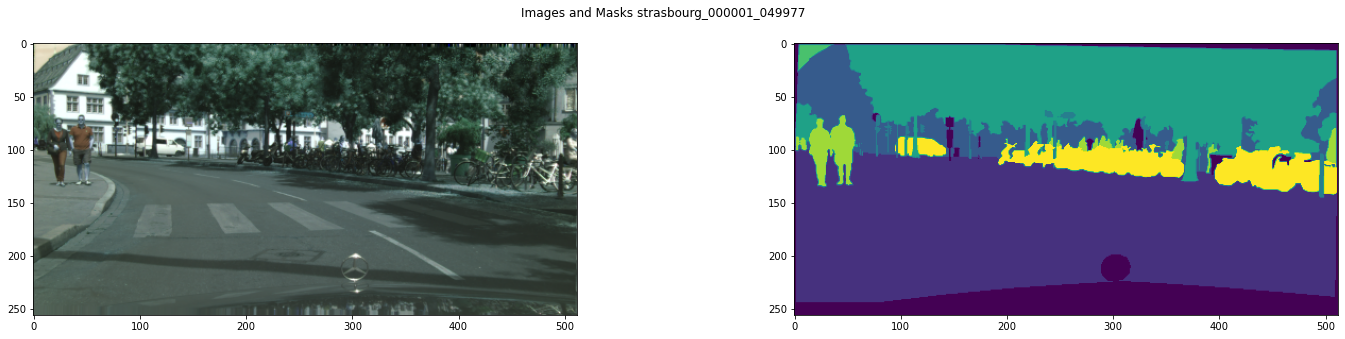

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 0 from batch collected-----------------


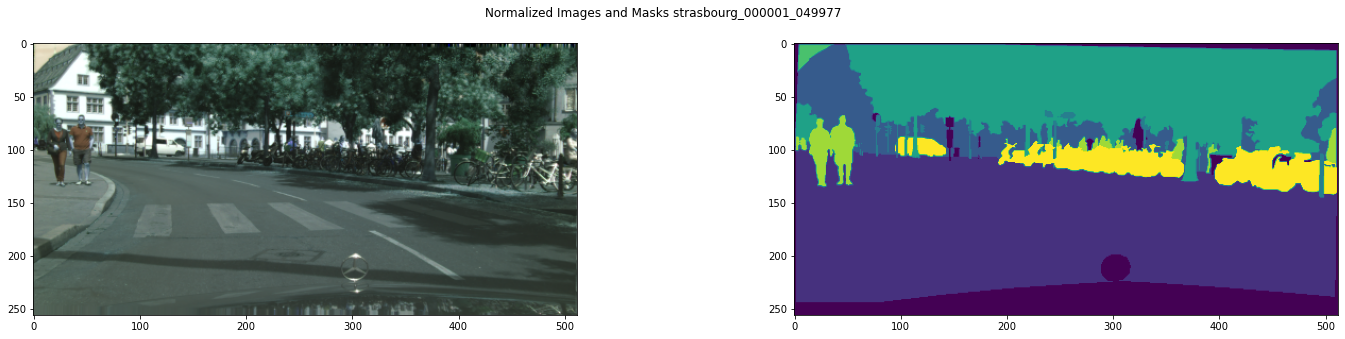

----------------Augmented Image and Mask 0 from batch collected-----------------


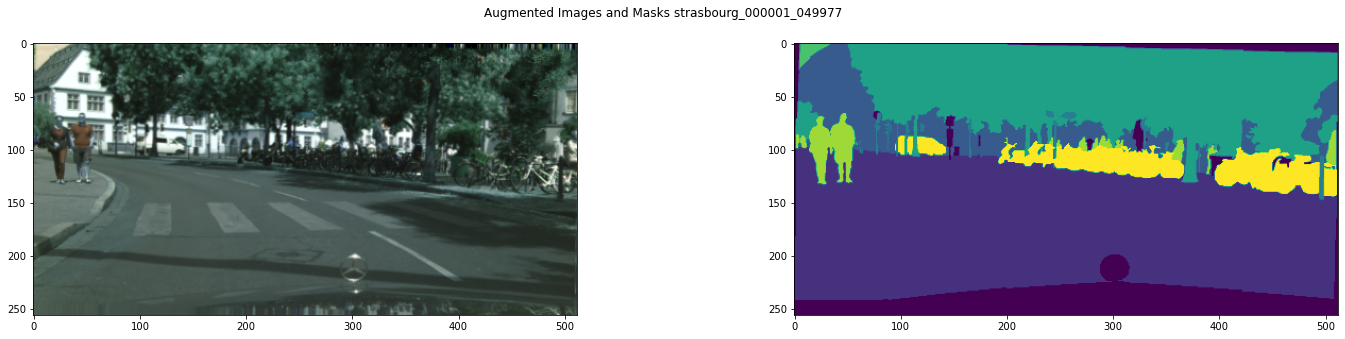

---------------- Image and Mask 0 from batch collected in Data Generator-----------------


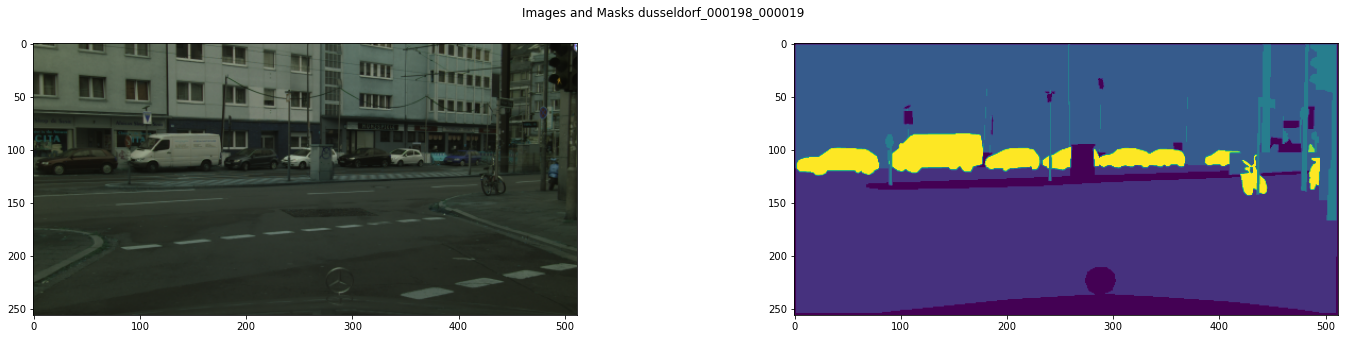

original height was  1024  and new height is  256
original width was  2048  and new width is  512
original channels was  3  and new channels is  3
----------------Normalized Image and Mask 1 from batch collected-----------------


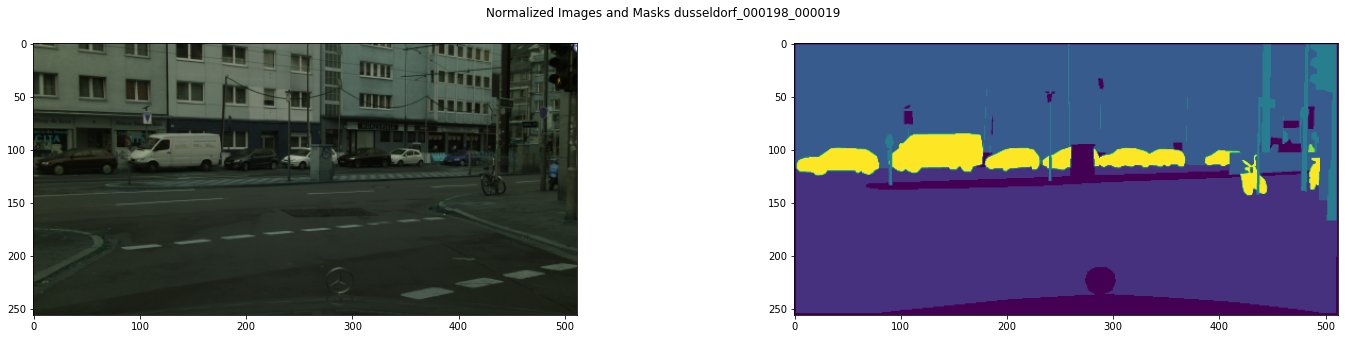

----------------Augmented Image and Mask 1 from batch collected-----------------


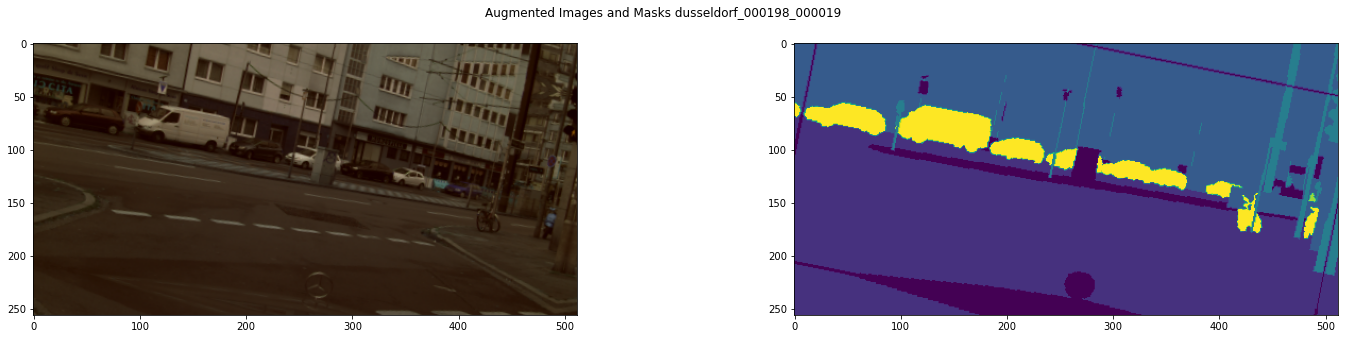

---------------- Image and Mask 1 from batch collected in Data Generator-----------------


(4, 256, 512, 3)

In [269]:
dataloader[0][0].shape

# Création du modèle UNET


In [215]:
# from unet_model import *

import skimage.io as io
import skimage.transform as trans

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
from tensorflow.keras import backend as keras
from tensorflow.keras.models import Model

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

In [201]:

# # Notre classe hérite de la classe Keras.utils.Sequence
# # Elle permet de créer un générateur de données
# # Cette classe parente vous assure dans le cas ou vous souhaitez utiliser du calcul parallèle avec vos threads, de garantir de parcourir une seule et unique fois vos données au cours d’une époch
# class Dataloader(Sequence):
#     """Load data from dataset to build bacthes
#     Args:
#         dataset : dataframe listing data and paths
#         n_sample : to work with a reduced dataset
#         batch_size: Integet number of images in batch.
#         shuffle: Boolean, if `True` shuffle dataset each epoch.
#         resize: Boolean,  if `True` resize images and mask to same dimensions
#         resize_width & resize_height: New dimensions after resizing
#         display: display images when calling dataloader
#         phase: allow to set if dataloader shall filter on train, val or test images/masks
#         augmentation: Variable defining augmentation of image and mask
#         normalization: Boolean,  if `True` normalizes images and masks RGB values ; The range for each individual colour is 0-255
#     """
#     # We provide one dataset, containing labelIds and 
#     def __init__(self, dataset, n_sample, batch_size=1, shuffle=False, resize=None, resize_width=256, resize_height=128, convert_mask=None, display=None, phase='train', augmentation=None, normalization=None):
#         self.n_sample = n_sample
#         self.phase = phase
#         self.dataset = dataset.loc[dataset['Phase'] == self.phase, :].sample(self.n_sample) #ou dataset si on veut prendre tour le jeu de donnée
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.resize = resize
#         self.resize_width = resize_width
#         self.resize_height = resize_height
#         self.convert_mask = convert_mask
#         self.augmentation = augmentation
#         self.normalization = normalization
#         self.display = display
#         self.on_epoch_end()

#     def __getitem__(self, i):
#         # collect batch images and masks
#         start = i * self.batch_size
#         stop = (i + 1) * self.batch_size
#         #print('start barch is ', start)
#         #print('stop barch is ', stop)
#         images = []
#         masks = []
#         for j in range(start, stop):
#             # Store entire paths to image_file and mask_file variable
#             image_file = list(self.dataset['Path_x'])[j]
#             print(image_file)
#             mask_file = list(self.dataset['Path_y'])[j]
#             unique_index_file = list(self.dataset['File_unique_index'])[j]

#             # OpenImages and masks using OpenCV ibrary, and convert in np array
#             image = cv2.imread(image_file)
#             #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#             mask = cv2.imread(mask_file, 0)
#             #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            
#             # apply resize
#             if self.resize:
#                 dim = (self.resize_width, self.resize_height)
#                 original_height = image.shape[0]
#                 original_width = image.shape[1]
#                 original_channels = image.shape[2]
#                 image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA) # resize image
#                 mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
#                 new_height = image.shape[0]
#                 new_width = image.shape[1]
#                 new_channels = image.shape[2]
                
            
#             if self.convert_mask:
#                 onehotencoder=False
#                 mask = convert_mask(mask, False)

#             # apply display
#             if self.display:
#                 #Display Image and Mask
#                 plt.figure(figsize=(25, 5))
#                 plt.subplots_adjust(hspace=0.5)
#                 plt.subplot(120 + 1 + 0)
#                 plt.imshow(image)
#                 plt.subplot(120 + 1 + 1)
#                 plt.imshow(mask)
#                 plt.grid(False)
#                 plt.suptitle(f'Images and Masks {unique_index_file}')
#                 plt.show()
#                 if self.resize:
#                     print('original height was ', original_height, ' and new height is ', new_height)
#                     print('original width was ', original_width, ' and new width is ', new_width)
#                     print('original channels was ', original_channels, ' and new channels is ', new_channels)
                    

#             # apply normalization : Normalizing RGB values ; The range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
#             if self.normalization:
#                 normalizedImg = np.zeros((800, 800))
#                 image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX) #image/255 ou normalizedImg
#                 mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX) #mask/255
#                 # apply display
#                 if self.display:
#                     print(f'----------------Normalized Image and Mask {j} from batch collected-----------------')
#                     #Display Image and Mask
#                     plt.figure(figsize=(25, 5))
#                     plt.subplots_adjust(hspace=0.5)
#                     plt.subplot(120 + 1 + 0)
#                     plt.imshow(image)
#                     plt.subplot(120 + 1 + 1)
#                     plt.imshow(mask)
#                     plt.grid(False)
#                     plt.suptitle(f'Normalized Images and Masks {unique_index_file}')
#                     plt.show()
            
#             # apply augmentations
#             if ((self.augmentation is not None) & (self.phase == 'train')):
#                 # Augment an image
#                 sample = self.augmentation(image=image, mask=mask)
#                 augmented_image, augmented_mask = sample['image'], sample['mask']
#                 # apply display
#                 if self.display:
#                     print(f'----------------Augmented Image and Mask {j} from batch collected-----------------')
#                     #Display Image and Mask
#                     plt.figure(figsize=(25, 5))
#                     plt.subplots_adjust(hspace=0.5)
#                     plt.subplot(120 + 1 + 0)
#                     plt.imshow(augmented_image)
#                     plt.subplot(120 + 1 + 1)
#                     plt.imshow(augmented_mask)
#                     plt.grid(False)
#                     plt.suptitle(f'Augmented Images and Masks {unique_index_file}')
#                     plt.show()
#                     images.append(augmented_image)
#                     masks.append(augmented_mask)
                    
#             # append image and mask to batch
#             images.append(image)
#             masks.append(mask)   

        
#         # transpose list of lists
#         image_batch = np.stack(images, axis=0) #A confirmer si images ou image
#         mask_batch = np.stack(masks, axis=0) #A confirmer si masks ou mask

#         #Add 1 dimension to return image_batch and mask_batch in 4 dimensions (batch number, height, width, channels), avec channel = 1 pour les masques et =3 pour les images
#         if len(mask_batch.shape) == 3:
#             mask_batch = np.expand_dims(mask_batch, axis = 3)

#         #print('mask_batch shape is ', mask_batch.shape)
#         return image_batch, mask_batch
    
#     def __len__(self):
#         """Denotes the number of batches per epoch"""
#         return len(self.dataset) // self.batch_size
    
#     def on_epoch_end(self):
#         """Callback function to shuffle dataset each epoch"""
#         if self.shuffle:
#             np.random.shuffle(self.dataset.values)

In [196]:
# Divide the number of images in directory by batch_size 
n_sample = 20
batch_size = 1
shuffle = True
resize = True
resize_width = 512
resize_height = 512
convert_mask = None
display_image_mask = False
phase = 'train'
augmentation = None 
normalization = True

learning_rate = 1e-4

# Generators
train_generators = Dataloader(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, convert_mask, display_image_mask, 'train', augmentation, normalization)
#train_images, train_masks = Dataloader(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, convert_mask, display_image_mask, 'train', augmentation, normalization)
val_generators = Dataloader(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, convert_mask, display_image_mask, 'val', augmentation, normalization)
#val_images, val_masks = Dataloader(clean_df, n_sample, batch_size, shuffle, resize, resize_width, resize_height, convert_mask, display_image_mask, 'val', augmentation, normalization)

In [200]:
train_generators[1][1].shape

c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\cologne\cologne_000134_000019_leftImg8bit.png
----------------Image and Mask 1 from batch collected-----------------


(1, 512, 512, 1)

In [193]:
    # Build U-Net model
    inputs = Input((resize_height, resize_width, 3))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    outputs = Conv2D(8, 1, activation = 'softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) #categorical_crossentropy #metrics dice / iou

    #model.summary()

In [216]:
#Train model
model.compile(optimizer=Adam(lr = 1e-4), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#model_test.summary()
results = model.fit_generator(
                            train_generators, 
                            validation_data=val_generators, 
                            validation_steps=10, 
                            #steps_per_epoch=250,
                            epochs=3, 
                            #callbacks=[earlystopper,checkpointer]
                            )

c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\erfurt\erfurt_000070_000019_leftImg8bit.png
----------------Image and Mask 10 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\cologne\cologne_000134_000019_leftImg8bit.png
----------------Image and Mask 1 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\jena\jena_000071_000019_leftImg8bit.png
----------------Image and Mask 15 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\dusseldorf\dusseldorf_000139_000019_leftImg8bit.png
----------------Image and Mask 6 from batch collect

InvalidArgumentError: Received a label value of 255 which is outside the valid range of [0, 8).  Label values: 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 88 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 96 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 120 120 120 120 120 120 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 128 151 151 151 151 143 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 151 151 151 151 151 151 151 151 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 64 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 143 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 143 151 151 151 151 151 151 151 151 151 151 151 151 151 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 159 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 143 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 24 24 24 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 48 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 24 32 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 112 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 104 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 104 24 24 24 24 24 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 104 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 135 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 104 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 135 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 104 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 135 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 128 128 88 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 135 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 128 120 80 80 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 24 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 120 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 128 128 120 88 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 128 128 128 120 80 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 104 128 128 128 128 96 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 80 88 120 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 143 80 80 104 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 24 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 135 80 80 96 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 104 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 128 80 80 88 128 128 128 96 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 72 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 120 80 80 80 128 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 72 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 96 80 80 80 120 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 72 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 88 80 80 80 112 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 72 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 143 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 72 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 72 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 143 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 72 24 24 24 24 24 24 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 112 48 24 24 24 24 24 32 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 88 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 72 24 24 24 24 24 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 128 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 88 72 40 24 24 24 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 96 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 88 80 80 56 24 24 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 151 151 151 151 151 151 151 151 151 151 151 151 151 151 143 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 88 80 80 80 72 40 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 151 151 151 151 151 151 151 151 151 151 151 151 151 104 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 120 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 151 151 151 151 151 151 151 151 151 151 151 151 143 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 88 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 151 151 151 151 151 151 151 151 151 151 151 88 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 88 80 80 80 80 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 151 151 151 151 151 151 151 151 143 96 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 88 80 80 80 80 80 80 135 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 143 151 151 151 151 151 128 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 104 80 80 80 80 80 80 80 80 120 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 120 120 120 96 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 120 80 80 80 80 80 80 80 80 80 80 88 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 167 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 167 167 167 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 175 175 167 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 175 175 167 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 167 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 167 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 175 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 167 80 80 80 80 80 80 80 112 120 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 135 80 80 80 80 80 88 151 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 151 80 80 88 167 128 128 80 120 175 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 167 175 175 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 175 175 175 175 175 175 175 175 175 175 175 175 175 167 80 128 151 80 80 80 80 80 80 80 80 120 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 128 128 151 175 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 88 175 175 175 175 175 175 175 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 120 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 175 175 175 175 175 175 88 80 80 80 80 80 80 80 80 80 80 80 80 135 175 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 104 175 175 175 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 175 175 175 175 175 175 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 175 175 175 175 175 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 120 159 159 159 159 159 159 159 159 159 159 120 80 128 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 175 175 175 175 175 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 175 175 175 175 175 175 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 135 151 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 175 175 175 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 128 128 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 135 175 175 175 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 175 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 175 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 135 135 120 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 183 183 183 183 120 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 143 151 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 128 135 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 159 135 128 135 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 159 135 128 135 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 175 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 159 159 135 128 135 159 159 159 128 80 80 80 80 80 80 80 120 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 175 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 159 159 135 128 135 159 159 159 151 80 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 159 135 128 135 159 159 159 159 104 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 128 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 128 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 88 88 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 104 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 120 159 151 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 80 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 151 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 143 183 135 96 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 128 80 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 151 159 159 159 159 120 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 120 183 183 183 183 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 135 128 143 159 159 159 151 104 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 135 128 151 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 88 80 80 80 167 183 183 183 183 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 159 112 80 80 80 80 80 120 128 104 80 80 80 80 80 80 80 80 80 80 80 80 120 151 128 151 159 159 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 159 151 143 143 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 120 183 183 183 183 183 183 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 159 159 88 80 80 80 80 120 128 96 80 80 80 80 80 80 80 80 80 80 80 104 159 151 128 151 159 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 88 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 135 183 183 183 183 183 183 96 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 159 159 112 80 128 88 80 120 128 88 80 80 80 80 80 80 80 80 80 80 88 151 159 151 128 151 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 135 183 183 183 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 159 159 128 80 128 104 80 120 128 88 80 80 80 80 80 80 80 80 80 80 128 159 159 151 128 151 159 159 159 159 159 159 159 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 135 80 80 135 183 183 183 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 159 159 159 80 128 104 80 120 128 88 80 80 80 80 80 80 80 80 80 80 159 159 159 151 128 151 159 159 159 159 159 159 159 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 120 80 80 135 183 183 183 183 183 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 135 128 143 159 159 159 159 159 159 159 104 128 104 80 120 128 88 80 80 80 80 80 80 80 80 80 112 159 159 159 151 128 151 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 135 88 80 135 183 183 183 183 183 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 80 80 80 80 128 159 159 159 151 128 151 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 80 96 183 183 183 183 183 143 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 80 80 80 80 151 159 159 159 151 128 151 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 159 159 80 80 143 183 183 183 183 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 88 120 120 135 159 159 159 159 151 128 151 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 96 183 183 183 183 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 151 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 104 159 159 159 159 159 159 159 151 128 151 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 159 135 80 135 167 183 183 183 183 183 143 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 104 159 159 159 159 159 159 159 151 128 151 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 159 151 167 183 183 183 183 183 183 183 183 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 104 159 159 159 159 159 159 159 151 128 151 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 104 159 159 159 159 159 159 159 151 128 151 159 159 159 159 159 159 159 159 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 183 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 120 128 104 80 120 128 88 80 80 80 80 80 120 159 159 159 159 159 159 159 151 128 151 159 159 159 159 159 159 159 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 183 183 183 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 128 128 104 80 120 128 88 80 80 80 80 80 120 159 159 159 159 159 159 159 151 128 151 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 151 128 128 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 135 128 104 80 120 128 88 80 80 80 80 80 120 159 159 159 159 159 159 199 231 239 215 199 199 183 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 151 128 128 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 183 183 183 183 183 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 151 128 104 80 120 128 88 80 80 80 80 80 120 159 159 159 159 159 207 239 239 239 239 239 239 239 239 239 199 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 151 128 128 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 159 128 104 80 120 128 88 80 80 80 80 80 120 159 159 159 159 159 215 239 239 239 239 239 239 239 239 239 239 239 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 151 128 135 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 183 183 183 183 183 183 143 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 135 128 151 159 159 159 159 159 159 159 159 128 104 80 120 128 88 80 80 80 80 80 112 159 159 159 159 159 239 239 239 239 239 239 239 239 239 239 239 239 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 151 128 135 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 159 159 128 104 80 120 128 88 80 80 80 80 80 104 159 159 159 159 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 128 135 167 159 167 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 159 159 128 104 80 128 128 88 80 80 80 80 80 104 159 159 159 159 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 128 135 175 159 167 175 175 167 167 159 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 159 151 128 104 80 128 128 80 80 80 80 80 80 80 159 159 159 159 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 128 135 167 159 167 167 167 167 175 167 175 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 96 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 120 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 159 151 128 88 80 128 128 80 80 80 80 80 80 80 128 159 159 159 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 80 80 40 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 128 135 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 159 151 128 88 80 128 128 80 80 80 80 80 80 80 88 159 159 159 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 80 40 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 128 135 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 135 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 159 151 128 88 80 128 128 80 80 80 80 80 80 80 80 128 159 159 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 64 24 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 128 135 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 143 80 80 80 80 80 80 80 80 80 80 80 88 120 128 159 159 159 159 159 159 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 159 143 128 88 80 128 128 80 80 80 80 80 80 80 80 80 128 159 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 64 24 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 128 135 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 80 112 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 128 80 80 80 104 135 159 120 159 159 128 128 159 159 159 159 159 159 159 159 104 128 88 80 128 128 80 80 80 80 80 80 80 80 80 80 104 159 239 239 239 239 239 239 239 239 239 239 239 239 159 80 80 80 80 80 80 80 80 64 24 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 151 128 135 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 135 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 128 120 88 80 104 120 120 120 120 120 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 120 80 80 80 80 120 135 80 135 159 128 128 159 159 159 159 159 159 159 128 88 128 88 80 128 128 80 80 80 80 80 80 80 80 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 199 80 80 80 80 80 80 80 80 64 24 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 151 128 135 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 159 159 159 159 104 88 128 88 80 128 128 80 80 80 80 80 80 80 80 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 199 80 72 56 56 56 56 56 56 56 24 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 151 128 135 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 120 120 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 159 183 183 167 159 128 88 128 88 80 128 128 80 80 80 80 80 80 80 80 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 199 80 64 24 24 24 24 24 24 40 24 24 24 24 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 151 128 135 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 120 120 120 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 159 159 159 159 159 159 159 159 159 159 159 128 128 159 159 167 183 183 175 128 120 88 128 88 80 128 128 80 80 80 80 80 80 80 80 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 199 80 64 24 24 24 24 24 24 40 24 24 64 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 151 128 135 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 128 135 159 159 167 183 183 183 151 88 88 128 88 80 128 128 80 80 80 80 80 80 80 80 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 215 80 64 24 24 24 24 24 24 56 80 80 120 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 151 128 135 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 128 135 159 159 167 183 183 183 159 151 88 128 88 80 128 128 80 80 80 80 80 80 80 80 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 56 80 80 120 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 151 128 135 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 128 135 159 159 159 183 183 183 175 159 120 128 88 80 128 128 80 80 80 80 80 80 167 96 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 64 80 80 120 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 88 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 151 112 128 120 104 104 120 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 135 159 120 80 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 128 135 159 159 167 183 183 183 183 159 151 128 88 80 128 128 80 80 80 80 80 135 183 143 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 143 135 104 151 112 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 64 72 80 48 48 143 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 128 135 159 159 175 183 183 183 183 159 159 135 88 80 128 128 183 183 159 80 96 183 183 167 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 143 183 183 183 183 120 80 143 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 104 48 48 48 135 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 128 80 80 80 80 80 80 80 80 80 120 159 159 159 159 159 159 159 159 159 159 159 128 135 159 159 183 183 183 183 183 159 159 143 88 80 128 128 183 183 159 80 104 183 183 183 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 143 183 183 183 183 143 96 183 159 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 135 48 48 72 159 159 159 159 159 159 159 159 159 159 175 167 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 135 207 207 159 159 207 207 167 159 159 159 159 128 135 159 167 183 183 183 183 175 159 159 151 88 80 128 128 183 183 159 80 104 183 183 183 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 143 183 183 183 183 167 104 183 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 135 48 48 104 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 135 255 255 183 167 255 255 183 159 159 159 159 128 135 159 159 183 183 183 183 175 159 159 159 88 80 128 128 183 183 159 80 135 183 183 183 80 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 143 183 183 183 183 183 120 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 143 48 48 120 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 120 215 255 255 231 255 255 183 159 159 159 159 128 135 159 159 183 183 183 183 175 159 159 159 96 80 128 135 183 183 143 80 135 183 183 183 104 80 80 120 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 143 183 183 183 183 183 159 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 48 48 135 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 159 159 159 159 159 151 151 159 159 159 159 128 143 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 120 207 255 255 255 255 255 231 167 159 159 143 128 135 143 143 175 167 159 183 175 159 159 159 112 80 128 143 183 183 135 80 135 183 183 183 104 80 80 135 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 143 183 183 183 183 183 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 159 48 48 143 159 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 151 143 151 159 159 159 159 135 143 159 159 159 159 128 143 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 167 255 255 255 255 255 255 255 247 159 159 143 128 135 143 143 175 151 143 183 167 159 159 159 120 80 128 143 183 183 135 80 135 183 183 183 104 80 80 159 239 239 239 239 239 239 239 239 239 239 239 239 239 80 64 24 24 24 24 24 24 183 183 183 183 183 183 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 48 48 159 159 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 151 128 151 159 159 159 159 135 143 159 159 159 159 128 143 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 191 255 255 255 255 255 255 255 255 255 199 159 143 128 135 143 143 175 151 143 183 167 159 159 159 135 80 128 143 183 183 120 80 135 183 183 183 104 80 80 159 239 239 239 239 239 239 239 239 239 239 239 239 239 135 120 80 80 80 80 24 24 183 183 183 183 183 167 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 48 72 159 159 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 151 128 151 159 159 159 159 135 143 159 159 159 159 128 143 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 255 255 255 255 255 255 255 255 255 255 207 159 143 128 135 143 143 175 151 151 183 159 159 159 159 143 56 128 143 183 183 88 48 120 183 183 183 56 64 64 159 239 239 239 239 239 239 239 239 239 239 239 239 239 135 135 135 135 135 135 135 135 183 183 183 183 183 159 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 48 72 159 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 151 128 151 159 159 159 159 135 143 159 159 159 151 128 143 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 255 255 255 255 255 255 255 255 255 255 231 159 143 128 143 143 143 175 151 151 183 159 159 159 159 159 56 128 143 183 183 88 56 120 183 183 183 48 48 48 143 239 239 239 239 239 239 239 239 239 239 239 239 239 135 135 135 135 135 135 135 135 183 183 183 183 183 135 183 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 48 72 159 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 151 128 151 159 159 159 159 135 143 159 159 159 151 128 143 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 80 80 80 80 80 80 80 80 255 255 255 255 255 255 255 255 255 255 231 159 143 128 143 143 143 175 151 151 183 159 159 159 159 159 56 128 143 183 183 88 56 120 183 183 183 56 48 48 143 239 239 239 239 239 239 239 239 239 239 239 239 239 135 135 135 135 135 135 135 135 183 183 183 183 183 120 183 183 167 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 96 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 175 159 159 159 48 64 159 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 151 128 151 159 159 159 159 135 143 159 159 159 151 128 143 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 151 80 80 80 80 80 80 80 80 255 255 255 255 255 255 255 255 255 255 231 159 143 128 143 135 135 175 143 151 183 159 159 159 159 143 56 128 143 183 183 88 56 120 183 183 151 56 56 56 143 239 239 239 239 239 239 239 239 239 239 239 239 239 135 135 135 135 135 135 135 135 183 183 183 183 183 104 183 183 143 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 159 48 48 159 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 151 128 151 159 159 159 159 135 143 159 159 159 151 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 104 80 80 80 80 80 80 80 80 255 255 255 231 120 183 247 255 255 255 255 159 151 128 143 135 135 175 143 151 183 159 159 159 120 56 56 128 143 183 167 72 56 151 183 183 151 56 56 56 151 239 239 239 239 239 239 239 239 239 239 239 239 239 135 135 135 135 135 135 135 135 183 183 183 183 183 88 183 183 96 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 48 48 159 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 151 128 151 159 159 159 159 135 143 159 159 159 151 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 143 88 80 80 80 80 80 80 80 80 80 231 255 255 231 56 56 183 255 255 255 255 159 151 128 143 135 135 175 143 151 183 159 143 80 56 56 56 128 143 120 56 56 56 104 120 120 88 56 56 56 128 239 239 239 239 239 239 239 239 239 239 239 239 239 135 135 135 135 135 135 135 135 183 183 183 183 183 88 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 128 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 183 167 159 159 159 159 48 48 143 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 143 159 159 159 151 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 143 104 72 56 56 56 72 72 80 80 80 80 80 120 159 151 151 56 56 104 255 255 255 143 104 151 128 143 135 135 175 143 167 183 56 56 56 56 56 56 88 56 56 56 56 56 56 56 56 56 56 56 56 48 215 239 239 239 239 239 239 239 239 239 239 239 239 135 135 135 135 135 135 135 135 183 183 183 167 104 56 183 183 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 48 48 120 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 143 159 159 159 151 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 104 80 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 128 56 112 112 151 143 167 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 120 143 239 239 239 239 239 239 239 239 239 167 135 135 135 135 135 135 135 135 183 167 104 56 56 56 72 104 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 48 48 104 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 143 159 159 159 151 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 104 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 128 56 112 112 56 112 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 120 135 135 135 135 135 135 135 135 151 72 56 56 56 56 56 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 159 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 48 48 72 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 143 159 159 159 151 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 143 104 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 128 56 112 112 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 120 135 135 135 135 135 135 135 135 56 56 56 56 56 56 56 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 48 48 48 159 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 143 159 159 159 151 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 143 96 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 56 80 80 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 120 135 135 135 128 96 96 72 56 56 56 56 56 56 56 56 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 48 48 48 135 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 143 159 159 159 143 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 143 96 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 88 96 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 88 48 48 120 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 143 159 159 159 143 128 151 159 159 159 159 159 159 159 159 159 159 159 159 159 159 159 135 104 96 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 143 48 48 88 159 159 159 159 159 159 159 159 159 159 159 167 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 151 159 159 159 143 128 151 159 159 159 159 159 159 159 159 135 104 104 80 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 159 88 48 72 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 167 159 159 159 159 159 159 151 128 151 159 159 159 159 128 151 159 159 159 143 128 151 159 159 159 159 135 104 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 159 88 48 72 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 151 128 151 159 159 159 159 128 151 159 159 159 143 128 151 159 159 159 96 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 143 48 48 72 159 159 159 159 159 159 159 159 159 159 159 159 183 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 143 128 151 159 159 159 159 128 151 159 159 159 143 128 112 104 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 175 159 159 159 159 159 159 88 48 48 72 159 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 143 128 151 159 159 159 159 128 151 135 104 80 88 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 143 48 48 48 72 159 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 183 159 159 159 159 159 159 159 143 128 151 159 159 159 135 128 72 56 56 56 88 128 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 88 48 48 48 72 159 159 159 159 159 159 159 159 159 159 159 159 175 183 183 183 183 183 183 183 175 159 159 159 159 159 159 159 143 128 151 104 96 56 56 128 72 56 56 56 88 128 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 159 48 48 48 48 48 48 48 48 88 104 120 159 159 159 159 159 159 167 183 183 183 183 183 183 183 175 159 159 159 120 104 104 104 120 128 72 56 56 56 56 128 72 56 56 56 104 128 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 135 48 48 48 48 48 48 48 48 48 48 48 48 48 88 104 120 159 167 183 183 183 183 183 183 183 135 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 112 128 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 120 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 80 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 112 128 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 88 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 88 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 112 128 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 183 183 159 159 159 159 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 112 128 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 72 80 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 88 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 167 183 183 183 183 183 183 183 183 183 183 159 159 159 120 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 183 183 183 183 183 183 183 104 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 80 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 143 183 183 183 183 183 183 183 183 183 183 159 159 159 88 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 167 183 183 183 183 183 183 88 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 135 183 183 183 183 183 183 183 183 183 183 56 80 104 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 183 183 88 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 151 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 183 183 88 56 56 56 56 56 56 56 88 128 72 56 56 56 72 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 151 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 120 183 183 183 183 183 183 88 56 56 56 56 56 56 56 88 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 151 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 120 183 183 183 183 183 183 56 56 56 56 56 56 56 56 88 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 151 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 88 183 183 183 183 183 183 56 56 56 56 56 56 56 56 88 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 183 183 183 183 183 183 183 183 183 151 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 88 183 183 183 183 183 167 56 56 56 56 56 56 56 56 88 128 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 183 183 183 183 183 183 183 183 183 151 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 183 183 183 183 183 151 56 56 56 56 56 56 56 56 72 88 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 72 72 56 56 183 183 183 183 183 183 183 183 183 167 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 167 183 183 183 183 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 183 183 183 183 183 183 183 183 183 183 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 183 183 183 183 183 183 183 183 183 183 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 135 183 183 183 183 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 120 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 183 183 183 183 183 183 183 183 183 183 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 120 183 183 183 167 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 112 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 88 183 183 183 183 183 183 183 183 183 183 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 135 183 183 183 135 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 104 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 104 183 183 183 183 183 183 183 183 183 183 104 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 104 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 104 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 120 183 183 183 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 183 183 183 183 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 104 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 183 183 167 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 104 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 120 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 112 128 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 183 183 183 183 183 183 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 112 128 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 151 183 183 183 183 183 183 183 183 183 167 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 112 128 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 135 183 183 183 183 183 183 183 151 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 112 128 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 104 120 120 120 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 112 128 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 112 128 88 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 112 112 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 120 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 104 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 112 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 72 80 80 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 72 80 80 80 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 80 80 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 64 72 80 120 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 112 128 128 104 80 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 112 128 128 96 72 80 80 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 112 128 128 88 56 56 72 80 80 80 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 112 128 128 88 56 56 56 56 64 72 80 80 64 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 112 104 80 56 56 56 56 56 56 56 56 64 56 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 56 56 56 56 56 56 56 56 56 56 48 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 80 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 80 72 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 80 80 64 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 80 72 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 48 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 8 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 16 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 0 0 8 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 0 0 8 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 0 0 8 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 0 0 0 0 0 8 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 8 0 0 0 0 0 0 0 0 0 0 0 16 24 24 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 24 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 24 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 24 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 24 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 24 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 32 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 48 48 48 48 40 24 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 48 48 48 48 48 40 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 40 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 24 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 40 24 24 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 40 24 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 32 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 32 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 24 40 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 40 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 32 24 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24 32 48 48 48 48 48 48 48 48 48 48 48 48 40 16 16 24 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 24 32 32 32 32 32 32 32 32 32 32 24 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
	 [[{{node loss_12/conv2d_250_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]

In [217]:
# #Conv block: Convolution block
# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)   #Not in the original network. 
#     x = Activation("relu")(x)
#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)  #Not in the original network
#     x = Activation("relu")(x)
#     return x

# #Encoder block: Conv block followed by maxpooling
# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p   

# #Decoder block
# #skip features gets input from encoder for concatenation
# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# #Build Unet using the blocks
# def build_unet(input_shape, n_classes):
#     inputs = Input(input_shape)
#     #inputs = Input((resize_height, resize_width, 3))

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b1 = conv_block(p4, 1024) #Bridge

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     if n_classes == 1:  #Binary
#         activation = 'sigmoid'
#     else:
#         activation = 'softmax'

#     outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
#     print(activation)

#     model = Model(inputs, outputs, name="U-Net")
#     return model

In [218]:
#from Functions_custo_by_Nico import build_unet
model_test = build_unet((resize_height,resize_width,3),8)
model_test.compile(optimizer=Adam(lr = 1e-4), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#model_test.summary()
results = model_test.fit_generator(
                            train_generators, 
                            validation_data=val_generators, 
                            validation_steps=10, 
                            #steps_per_epoch=250,
                            epochs=3, 
                            #callbacks=[earlystopper,checkpointer]
                            )

softmax
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\tubingen\tubingen_000106_000019_leftImg8bit.png
----------------Image and Mask 2 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\dusseldorf\dusseldorf_000089_000019_leftImg8bit.png
----------------Image and Mask 13 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\hamburg\hamburg_000000_029676_leftImg8bit.png
----------------Image and Mask 0 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\jena\jena_000071_000019_leftImg8bit.png
----------------Image and Mask 15 from b

InvalidArgumentError: Received a label value of 255 which is outside the valid range of [0, 8).  Label values: 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 58 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 74 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 181 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 181 181 173 165 165 165 165 165 165 165 165 173 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 181 181 181 173 165 165 165 165 165 173 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 181 181 181 173 165 165 165 165 173 181 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 181 181 181 181 181 165 165 165 173 181 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 181 181 181 181 173 165 173 181 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 181 181 181 181 173 173 181 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 181 181 173 181 181 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 181 173 165 165 165 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 181 181 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 165 165 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 165 165 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 165 165 165 165 165 165 165 165 165 165 156 165 165 165 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 165 165 165 165 165 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 165 165 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 165 165 156 156 156 165 165 165 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 165 156 156 156 156 165 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 165 165 165 165 165 165 165 165 165 156 165 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 165 165 165 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 165 165 156 156 156 156 156 156 156 156 156 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 99 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 99 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 99 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 115 165 165 165 99 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 99 165 165 165 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 99 107 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 99 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 107 165 165 148 148 132 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 115 123 148 165 140 99 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 99 99 156 165 156 99 99 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 99 123 165 165 165 99 99 99 140 165 165 165 165 165 165 156 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 99 156 165 165 165 115 99 99 99 148 165 165 165 165 165 123 107 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 107 165 165 165 165 123 107 107 99 132 165 165 165 165 156 99 107 132 132 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 148 165 165 165 165 165 165 156 99 148 165 165 165 165 165 148 123 99 132 165 165 165 156 107 99 107 132 132 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 99 132 165 165 165 165 156 115 140 165 165 165 165 165 165 165 132 99 115 165 165 148 99 99 99 107 132 132 115 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 99 99 156 165 165 148 99 99 123 165 165 165 165 165 165 165 148 99 99 99 99 99 99 99 99 107 132 132 115 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 99 99 123 165 123 99 99 99 107 165 165 165 165 165 165 140 132 123 99 99 99 99 99 99 99 107 132 132 115 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 99 99 99 123 99 99 115 99 99 140 165 165 165 165 165 123 99 99 99 99 99 99 99 99 99 107 132 132 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 99 99 99 99 99 132 140 99 99 99 140 165 165 165 156 107 99 99 99 99 99 99 99 99 99 107 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 99 99 99 99 115 165 132 99 99 99 99 107 132 115 99 99 99 99 99 99 99 99 99 99 99 107 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 99 99 99 107 165 165 115 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 107 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 99 99 99 140 165 165 107 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 107 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 99 99 165 165 165 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 107 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 123 165 165 165 107 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 107 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 156 165 165 165 115 99 99 99 99 99 99 99 107 107 99 99 99 99 99 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 107 165 165 165 165 132 99 99 99 99 99 99 99 107 156 107 99 99 99 99 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 123 165 165 165 165 132 99 99 99 99 99 99 99 99 165 165 123 115 156 107 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 140 165 165 165 165 132 99 99 99 99 99 99 99 99 148 165 165 165 165 123 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 156 165 165 165 148 107 99 99 99 99 99 99 99 99 156 165 165 165 165 140 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 99 99 99 99 99 123 165 148 165 165 165 140 132 115 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 99 99 99 99 148 165 165 165 165 165 156 99 99 99 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 99 99 99 123 165 165 165 165 165 165 132 99 99 99 99 99 99 99 99 132 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 99 99 99 148 165 165 165 165 165 165 132 115 99 99 99 99 99 99 99 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 123 115 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 99 99 99 99 148 165 165 165 165 165 165 148 165 123 99 99 99 99 99 99 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 90 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 99 99 99 165 165 165 165 165 165 165 165 165 140 99 99 99 99 99 99 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 165 165 165 165 165 165 115 82 82 140 165 165 165 165 165 90 90 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 132 132 132 165 165 165 165 165 165 165 165 165 156 99 99 99 99 99 99 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 107 165 165 165 165 165 165 107 82 82 140 165 165 165 165 132 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 99 99 99 99 99 99 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 123 107 82 82 165 165 165 165 165 165 123 82 82 82 107 156 165 165 107 82 82 82 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 99 99 99 99 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 132 165 165 165 165 165 132 82 82 82 82 140 165 156 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 99 99 99 99 99 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 90 140 165 165 165 165 165 165 165 132 123 123 123 82 82 82 82 82 82 115 165 165 165 165 165 132 82 82 82 82 140 165 115 82 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 99 99 99 99 99 132 132 132 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 107 156 165 165 165 165 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 115 90 82 82 82 82 82 82 156 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 99 99 99 99 132 132 123 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 82 82 82 107 165 165 165 165 132 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 90 140 165 156 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 99 99 99 132 132 123 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 82 123 165 165 165 90 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 115 123 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 99 99 132 132 123 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 82 82 140 165 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 107 132 132 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 82 132 115 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 132 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 123 123 123 123 123 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 90 82 82 82 82 82 82 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 82 82 82 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 82 123 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 148 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 82 82 82 123 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 82 82 82 82 82 82 82 132 132 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 90 140 132 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 115 140 132 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 132 140 132 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 156 140 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 90 165 140 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 197 206 206 189 189 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 115 165 140 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 165 165 165 189 197 206 206 206 206 206 206 206 206 206 206 206 206 189 189 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 132 165 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 165 173 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 156 165 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 90 90 115 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 90 156 165 165 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 25 25 25 58 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 156 156 156 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 107 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 25 25 25 58 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 132 123 123 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 25 25 25 58 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 90 165 165 173 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 25 25 25 58 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 189 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 25 25 25 58 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 189 189 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 25 25 25 58 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 189 189 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 25 25 25 165 165 165 140 156 156 156 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 189 189 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 25 25 25 165 165 165 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 230 255 107 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 189 189 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 25 25 25 165 165 165 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 189 189 189 173 165 173 189 189 173 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 148 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 189 189 189 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 189 189 189 189 189 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 25 25 25 165 165 165 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 173 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 189 189 189 181 165 165 165 165 165 165 165 165 173 189 189 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 189 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 25 25 25 165 165 165 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 189 189 189 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 189 189 189 189 173 165 189 189 181 165 165 173 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 255 255 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 189 189 189 165 165 165 165 165 189 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 25 25 25 165 165 165 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 90 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 214 255 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 82 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 189 189 189 173 189 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 41 58 90 165 165 165 148 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 189 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 189 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 90 165 165 165 165 148 148 165 165 165 165 165 165 165 165 165 165 173 189 189 189 189 189 181 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 189 189 189 165 165 181 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 173 123 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 107 82 82 82 82 82 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 90 165 165 165 165 148 148 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 230 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 90 82 82 82 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 189 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 90 165 165 165 165 148 148 165 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 189 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 90 165 165 165 165 148 148 165 165 165 165 165 165 189 189 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 189 148 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 58 90 165 165 165 165 148 148 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 173 189 82 82 82 82 82 82 230 123 107 230 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 90 165 165 165 165 148 148 173 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 214 255 82 82 82 148 173 173 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 189 189 189 189 197 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 115 58 25 58 148 165 90 90 165 165 165 165 148 148 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 148 206 206 206 206 206 206 206 173 165 165 165 165 90 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 214 255 123 82 148 255 255 255 255 255 255 255 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 189 189 189 189 189 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 132 25 25 25 25 132 165 90 90 165 165 165 165 148 156 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 148 206 206 206 206 206 206 206 90 148 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 189 255 189 107 255 255 255 255 255 255 255 255 214 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 132 25 25 74 115 148 189 148 148 189 189 173 165 148 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 148 206 206 206 206 206 206 206 49 90 165 165 165 107 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 107 255 255 230 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 115 123 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 181 189 189 206 206 206 206 206 206 206 206 206 206 206 173 148 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 140 206 206 206 206 206 123 107 49 49 148 165 165 123 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 189 255 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 173 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 148 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 123 132 132 123 66 49 49 49 49 49 49 49 90 165 165 90 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 173 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 74 132 49 49 49 49 49 49 49 49 49 49 148 115 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 173 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 148 206 206 165 107 66 123 189 206 206 107 49 123 206 206 206 206 206 206 206 123 123 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 66 49 49 107 49 49 49 49 49 49 49 49 49 49 49 66 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 173 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 90 123 123 107 49 49 90 123 148 206 148 123 123 107 189 206 107 165 206 206 206 123 123 123 123 123 107 107 123 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 173 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 107 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 66 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 173 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 214 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 82 82 82 82 82 82 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 230 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 140 165 165 165 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 82 82 82 82 82 82 140 165 165 148 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 140 165 156 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 90 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 82 82 82 82 132 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 82 82 82 107 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 165 165 165 165 165 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 82 82 156 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 165 165 165 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 165 181 181 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 115 165 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 156 99 99 99 99 99 132 132 132 132 132 148 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 165 197 206 206 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 156 165 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 99 99 99 99 99 99 99 99 99 99 140 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 173 206 206 206 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 107 165 165 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 140 99 99 99 99 99 99 99 99 99 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 123 165 165 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 99 99 99 99 99 99 99 99 140 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 165 165 165 165 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 156 165 165 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 115 99 99 99 99 99 99 99 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 165 165 165 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 90 82 82 82 82 82 165 165 165 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 140 99 99 99 99 99 99 140 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 165 181 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 123 255 255 255 255 255 255 255 255 255 255 206 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 90 165 165 165 165 165 148 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 99 99 99 99 99 99 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 222 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 107 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 99 99 115 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 165 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 74 74 74 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 230 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 107 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 99 115 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 82 74 74 74 66 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 230 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 123 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 99 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 230 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 123 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 140 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 82 82 255 255 255 255 255 255 255 255 255 255 230 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 123 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 82 82 82 74 74 255 255 255 255 255 255 255 255 255 255 230 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 123 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 123 123 123 123 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 74 66 58 58 58 82 255 255 255 255 255 255 255 255 255 255 230 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 107 82 82 82 82 82 123 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 165 165 181 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 165 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 74 82 82 74 58 58 58 58 58 58 107 255 255 255 255 255 255 255 255 255 255 230 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 82 82 82 82 123 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 148 206 206 189 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 58 58 58 58 58 58 58 107 255 255 255 255 255 255 255 255 255 255 214 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 123 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 165 165 197 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 132 255 255 255 255 255 255 255 255 255 255 214 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 82 82 82 82 115 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 181 165 165 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 156 255 255 255 255 255 255 255 255 255 255 230 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 156 165 165 82 82 82 82 82 82 82 107 156 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 156 255 255 255 255 255 255 255 255 255 255 255 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 115 165 165 82 82 82 82 82 82 82 82 90 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 132 255 255 255 255 255 255 255 255 255 255 214 82 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 90 165 140 82 82 82 82 82 82 82 82 82 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 197 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 255 255 255 255 255 255 255 255 255 255 189 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 132 140 82 82 82 82 82 82 82 82 82 140 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 255 255 255 255 255 255 255 255 255 189 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 90 132 82 82 82 82 82 82 82 82 82 132 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 165 173 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 123 165 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 230 255 255 255 255 255 255 255 140 82 82 82 82 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 132 82 82 90 82 82 82 82 82 82 82 82 82 115 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 156 107 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 123 123 90 49 49 49 49 49 90 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 181 255 255 255 255 255 255 255 107 58 58 74 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 123 123 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 82 82 82 82 107 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 132 58 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 123 49 49 49 49 49 49 49 49 49 49 66 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 255 255 255 255 255 255 255 107 58 58 58 58 66 148 165 165 165 165 165 165 165 132 165 165 165 165 165 132 82 82 82 82 82 107 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 82 82 82 82 82 82 82 156 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 173 58 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 156 255 255 255 255 255 255 107 58 58 58 58 58 82 165 165 165 165 165 156 82 82 132 165 165 165 165 90 82 82 82 82 82 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 90 82 82 82 82 82 82 82 82 82 82 82 82 90 156 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 58 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 107 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 156 255 255 255 255 255 107 58 58 58 58 58 58 74 148 165 165 165 115 82 82 82 140 165 165 132 82 82 82 82 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 165 165 165 165 132 82 82 82 82 82 82 82 82 82 82 82 82 82 90 140 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 58 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 230 255 255 255 82 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 156 165 107 82 82 82 82 82 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 123 165 165 165 165 90 82 82 82 82 82 82 82 82 82 82 82 82 82 107 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 74 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 74 90 140 82 82 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 82 82 123 165 165 165 132 82 82 82 82 82 82 82 82 82 82 82 82 82 99 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 123 165 165 140 82 82 82 82 82 82 82 82 82 82 82 82 82 99 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 82 82 82 82 82 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 123 165 115 82 82 82 82 82 82 82 82 115 165 123 90 82 99 140 140 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 74 82 90 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 140 82 82 82 82 82 82 82 82 82 82 82 82 82 82 82 156 165 165 165 90 99 140 140 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 82 82 82 82 82 82 82 82 82 115 165 165 165 165 132 99 140 140 107 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 165 165 115 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 82 82 82 82 82 82 82 82 82 82 82 82 82 82 156 165 165 165 165 165 107 140 140 107 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 140 165 165 58 74 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 82 82 82 82 82 82 82 115 165 165 165 165 165 165 156 140 140 107 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 58 58 107 165 165 165 165 165 165 165 165 165 165 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 82 82 82 82 82 123 165 165 165 165 165 165 156 140 140 140 123 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 49 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 66 123 206 206 206 206 206 189 189 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 148 123 58 58 74 165 165 165 156 156 165 165 165 165 115 82 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 82 82 82 82 82 82 123 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 66 49 90 206 206 206 206 206 165 148 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 74 58 58 58 140 165 123 58 66 107 165 165 123 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 82 82 82 82 123 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 123 123 107 49 49 49 49 90 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 99 58 58 58 58 66 115 82 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 165 165 165 156 82 82 82 82 82 82 82 82 82 82 82 123 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 123 123 123 66 49 49 49 49 49 49 49 49 49 49 49 66 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 115 165 165 165 165 165 165 165 165 165 165 165 165 165 115 82 82 82 82 82 82 82 82 82 82 123 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 90 140 165 165 165 140 123 107 107 156 165 165 165 156 82 82 82 82 82 82 82 82 82 82 132 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 165 206 206 206 206 206 206 206 206 206 123 123 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 165 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 74 82 82 115 115 82 82 82 82 82 82 132 165 165 165 132 82 82 82 82 82 82 82 82 107 165 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 148 206 206 206 206 206 206 189 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 148 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 82 82 82 82 82 115 165 165 165 115 82 82 82 82 82 82 107 156 165 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 123 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 74 82 82 82 82 82 82 132 165 165 165 165 107 82 82 82 82 132 165 165 165 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 107 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 82 82 82 82 156 165 165 165 165 82 82 82 82 115 165 165 165 165 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 189 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 66 74 90 165 165 165 165 123 82 82 82 82 123 165 165 165 165 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 90 148 206 189 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 107 82 82 82 82 82 140 165 165 165 165 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 115 74 82 82 82 82 82 156 165 165 165 165 165 165 165 165 165 165 156 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 148 140 58 58 58 74 82 82 90 165 165 165 165 165 165 165 165 165 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 74 58 58 58 58 58 66 90 165 165 165 165 165 165 165 165 165 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 165 165 165 165 165 165 165 165 165 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 123 165 165 165 165 165 165 165 165 165 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 107 165 165 165 165 165 165 165 165 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 148 165 165 165 165 165 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 123 165 165 165 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 123 165 165 165 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 123 140 140 156 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 140 140 123 107 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 107 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 107 107 107 115 132 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 115 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 107 49 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 189 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 165 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 123 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 107 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 107 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 90 206 206 206 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 165 165 165 165 165 123 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 189 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 148 165 165 165 165 165 165 107 74 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 148 206 206 206 206 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 165 165 165 165 165 99 58 99 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 66 206 206 206 206 206 189 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 107 107 107 82 58 58 123 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 90 123 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 148 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 165 165 165 165 165 165 165 165 165 165 148 99 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 107 165 165 165 165 165 165 165 165 165 165 165 99 58 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 107 99 58 123 165 165 165 165 123 58 58 58 74 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 123 90 165 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 148 165 165 165 74 58 58 58 58 140 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 123 123 49 49 49 49 49 123 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 107 74 58 58 58 58 58 107 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 123 90 49 49 49 49 49 49 49 49 49 107 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 123 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 90 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 123 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 140 165 165 165 165 165 165 148 107 107 107 123 165 165 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 123 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 189 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 165 165 165 82 58 58 58 58 74 123 165 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 123 123 123 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 165 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 148 165 165 165 165 107 58 58 58 58 58 58 58 140 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 123 123 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 107 206 206 206 206 206 206 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 107 165 165 165 123 58 58 58 58 58 58 58 58 123 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 123 123 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 66 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 165 165 148 58 58 58 58 58 58 58 58 58 107 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 165 206 206 206 206 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 123 165 74 58 58 58 58 58 58 58 58 58 107 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 107 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 123 58 58 58 58 58 58 58 58 58 58 82 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 148 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 82 165 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 90 123 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 148 165 165 165 165 165 165 165 123 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 165 165 165 165 90 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 148 165 165 165 165 165 123 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 99 165 165 165 165 148 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 140 165 165 148 74 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 74 165 107 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 66 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 90 49 49 49 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 90 49 49 49 49 49 49 148 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 66 49 49 49 49 49 49 49 123 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 90 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 66 49 49 49 49 49 49 49 49 49 49 66 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 165 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 148 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 66 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 123 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 189 206 206 206 206 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 66 206 206 206 206 206 206 206 206 206 206 206 206 189 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 107 123 206 206 206 206 206 206 206 206 206 165 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 66 123 123 123 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 189 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 165 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 206 165 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 206 189 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 206 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 165 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 206 66 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 123 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 206 90 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 189 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 148 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 107 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 74 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 8 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 16 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 0 0 8 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 0 0 8 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 0 0 8 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 0 0 0 0 0 8 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 8 0 0 0 0 0 0 0 0 0 0 0 16 25 25 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 25 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 25 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 25 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 25 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 25 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 25 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 25 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 41 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 25 41 49 49 49 49 49 49 49 49 49 49 49 49 49 58 58 49 16 16 33 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 33 25 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 25 33 49 49 49 49 49 49 49 49 49 49 49 58 49 16 16 25 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 25 33 33 33 33 33 33 33 33 33 33 33 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
	 [[{{node loss_13/conv2d_269_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]

In [168]:
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Fit model
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit_generator(
                            train_generators, 
                            validation_data=val_generators, 
                            validation_steps=10, 
                            #steps_per_epoch=250,
                            epochs=3, 
                            #callbacks=[earlystopper,checkpointer]
                            )

c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\monchengladbach\monchengladbach_000000_032540_leftImg8bit.png
(512, 512, 8)
----------------Image and Mask 2 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\hanover\hanover_000000_042581_leftImg8bit.png
(512, 512, 8)
----------------Image and Mask 18 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\strasbourg\strasbourg_000001_008576_leftImg8bit.png
(512, 512, 8)
----------------Image and Mask 13 from batch collected-----------------
c:\Users\blanc\OpenClassrooms\IA_Project8_Openclassrooms_VoitureAutonome\Dataset\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\train\strasbourg\strasbourg_000000_01

InvalidArgumentError: Can not squeeze dim[2], expected a dimension of 1, got 512
	 [[{{node metrics_16/acc/Squeeze}}]]

In [43]:
model = unet()
#model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)

history = model.fit(train_generators,  
                    verbose=1,
                    epochs=50,
                    use_multiprocessing=True,
                    workers=30,
                    validation_data=val_generators,
                    #callbacks=[model_checkpoint]
                    )

# Train model on dataset
#model.fit_generator(myGene,steps_per_epoch=300,epochs=1,callbacks=[model_checkpoint])
#model.fit_generator(generator=train_generators, validation_data=val_generators, use_multiprocessing=True, workers=6)
#model.fit_generator(train_generators) #, steps_per_epoch=steps, epochs=8, callbacks=callbacks, workers=8)

#testGene = testGenerator("data/membrane/test")
#results = model.predict_generator(testGene,30,verbose=1)
#saveResult("./results/val",results)

TypeError: ('Keyword argument not understood:', 'input')

In [40]:
# import numpy as np 
# import os
# import skimage.io as io
# import skimage.transform as trans
# import numpy as np
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from tensorflow.keras import backend as keras


# def unet(pretrained_weights = None,input_size = (256,256,1)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = concatenate([drop4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#     model = Model(input = inputs, output = conv10)

#     model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy']) #categorical_crossentropy #metrics dice / iou
    
#     #model.summary()

#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)

#     return model
